### ECON 138 CAPSTONE PROJECT
# Political Dynasty and Poverty Incidence in the Philippines

###### BY: Barra, Giane Gwyneth; Estiller, Ma. Mechaela; Gutang, John Lloyd; Mariano, Belinda Rose; Mendoza, Gwyneth Nicole

In [ ]:
%pip install numpy
%pip install pandas
%pip install statsmodels
%pip install linearmodels
%pip install matplotlib
%pip install seaborn
%pip install openpyxl
%pip install geopandas
%pip install sphfile
%pip install networkx
%pip install pyvis
%pip install ipython
%pip install scipy
%pip install --upgrade pandas linearmodels
%pip install python-louvain

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py) ... done
  Created wheel for python-louvain:

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib as plt
from matplotlib import pyplot as plt
from linearmodels import RandomEffects
import seaborn as sns
import geopandas as gpd
import networkx as nx
from pyvis.network import Network
from linearmodels.panel import PanelOLS
from networkx.algorithms import bipartite
from itertools import combinations
from collections import defaultdict
from networkx.algorithms.community import girvan_newman
import community as community_louvain
from scipy.sparse import triu
from networkx.algorithms.bipartite.matrix import biadjacency_matrix

## Geospatial Analysis

In [3]:
# Load the shapefile
shapefile_path = "ph.shp"
gdf_regions = gpd.read_file(shapefile_path)

# Check if it loaded successfully
print(gdf_regions.head())

     id                                  name                  source  \
0  PH11                                 Davao  https://simplemaps.com   
1  PH13                                Caraga  https://simplemaps.com   
2  PH10                     Northern Mindanao  https://simplemaps.com   
3  PH14  Autonomous Region in Muslim Mindanao  https://simplemaps.com   
4  PH09                   Zamboanga Peninsula  https://simplemaps.com   

                                            geometry  
0  MULTIPOLYGON (((125.77687 6.89403, 125.76775 6...  
1  MULTIPOLYGON (((126.38347 7.89956, 126.36302 7...  
2  MULTIPOLYGON (((125.37429 7.99776, 125.37436 7...  
3  MULTIPOLYGON (((123.86182 7.70347, 123.86922 7...  
4  MULTIPOLYGON (((123.68897 7.9683, 123.68897 7....  


In [4]:
# Load the poverty rate data
# Ensure your CSV file has columns 'Region' and 'Poverty_Rate'
df_poverty = pd.read_csv("philippines-poverty-rate.csv")  # Poverty data
print(df_poverty.head())

                             Region  2003  2006  2009  2012  2015  2018  2021
0                       Philippines  30.4  26.6  26.3  25.2  21.6  16.7  18.1
1           NATIONAL CAPITAL REGION   7.3   4.7   3.6   3.9   3.9   2.2   3.5
2  CORDILLERA ADMINISTRATIVE REGION  31.2  26.0  25.1  22.8  19.7  12.0   9.9
3                          REGION I  30.2  25.9  22.0  18.5  13.1   9.9  14.4
4                         REGION II  24.5  26.8  25.5  22.1  15.8  16.3  15.4


In [5]:
region_mapping = {'REGION XI': 'Davao',
    'REGION IV-A': 'Calabarzon',
    'REGION VII': 'Central Visayas',
    'REGION I': 'Ilocos',
    'REGION V': 'Bicol',
    'REGION III': 'Central Luzon',
    'REGION II': 'Cagayan Valley',
    'REGION IX': 'Zamboanga Peninsula',
    'REGION VIII': 'Eastern Visayas',
    'REGION X': 'Northern Mindanao',
    'CORDILLERA ADMINISTRATIVE REGION': 'Cordillera Administrative Region',
    'REGION IV-B': 'Mimaropa',
    'REGION VI': 'Western Visayas',
    'REGION XII': 'Soccsksargen',
    'NATIONAL CAPITAL REGION': 'National Capital Region',
    'REGION XIII': 'Caraga'
}

# Replace the values in the 'Region' column
df_poverty['Region'] = df_poverty['Region'].replace(region_mapping)

# Print the unique values in the 'Region' column to verify the changes
print(df_poverty['Region'].unique())

['Philippines' 'National Capital Region'
 'Cordillera Administrative Region' 'Ilocos' 'Cagayan Valley'
 'Central Luzon' 'Calabarzon' 'Mimaropa' 'Bicol' 'Western Visayas'
 'Central Visayas' 'Eastern Visayas' 'Zamboanga Peninsula'
 'Northern Mindanao' 'Davao' 'Soccsksargen' 'Caraga'
 'Autonomous Region in Muslim Mindanao']


In [6]:
print(gdf_regions.head())
print(gdf_regions.info())

     id                                  name                  source  \
0  PH11                                 Davao  https://simplemaps.com   
1  PH13                                Caraga  https://simplemaps.com   
2  PH10                     Northern Mindanao  https://simplemaps.com   
3  PH14  Autonomous Region in Muslim Mindanao  https://simplemaps.com   
4  PH09                   Zamboanga Peninsula  https://simplemaps.com   

                                            geometry  
0  MULTIPOLYGON (((125.77687 6.89403, 125.76775 6...  
1  MULTIPOLYGON (((126.38347 7.89956, 126.36302 7...  
2  MULTIPOLYGON (((125.37429 7.99776, 125.37436 7...  
3  MULTIPOLYGON (((123.86182 7.70347, 123.86922 7...  
4  MULTIPOLYGON (((123.68897 7.9683, 123.68897 7....  
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        17 non-null     object  
 

In [7]:
# Inspect the columns of both dataframes
print("Columns in gdf_regions:", gdf_regions.columns)
print("Columns in df_poverty:", df_poverty.columns)

# Merge the shapefile data with the poverty rate data
# Assuming the common column is 'Region' in df_poverty and 'name' in gdf_regions
gdf_regions = gdf_regions.merge(df_poverty, left_on='name', right_on='Region')

# Verify the merge
print("Columns in gdf_regions after merge:", gdf_regions.columns)

Columns in gdf_regions: Index(['id', 'name', 'source', 'geometry'], dtype='object')
Columns in df_poverty: Index(['Region', '2003', '2006', '2009', '2012', '2015', '2018', '2021'], dtype='object')
Columns in gdf_regions after merge: Index(['id', 'name', 'source', 'geometry', 'Region', '2003', '2006', '2009',
       '2012', '2015', '2018', '2021'],
      dtype='object')


In [8]:
print(gdf_regions.head())
print("Number of rows after merge:", len(gdf_regions))

     id                                  name                  source  \
0  PH11                                 Davao  https://simplemaps.com   
1  PH13                                Caraga  https://simplemaps.com   
2  PH10                     Northern Mindanao  https://simplemaps.com   
3  PH14  Autonomous Region in Muslim Mindanao  https://simplemaps.com   
4  PH09                   Zamboanga Peninsula  https://simplemaps.com   

                                            geometry  \
0  MULTIPOLYGON (((125.77687 6.89403, 125.76775 6...   
1  MULTIPOLYGON (((126.38347 7.89956, 126.36302 7...   
2  MULTIPOLYGON (((125.37429 7.99776, 125.37436 7...   
3  MULTIPOLYGON (((123.86182 7.70347, 123.86922 7...   
4  MULTIPOLYGON (((123.68897 7.9683, 123.68897 7....   

                                 Region  2003  2006  2009  2012  2015  2018  \
0                                 Davao  34.4  30.6  31.4  30.7  22.0  19.1   
1                                Caraga  54.2  49.2  54.4  40.3  3

In [9]:
# Display the first few rows
print(gdf_regions.head())

# Display the last few rows
print(gdf_regions.tail())

     id                                  name                  source  \
0  PH11                                 Davao  https://simplemaps.com   
1  PH13                                Caraga  https://simplemaps.com   
2  PH10                     Northern Mindanao  https://simplemaps.com   
3  PH14  Autonomous Region in Muslim Mindanao  https://simplemaps.com   
4  PH09                   Zamboanga Peninsula  https://simplemaps.com   

                                            geometry  \
0  MULTIPOLYGON (((125.77687 6.89403, 125.76775 6...   
1  MULTIPOLYGON (((126.38347 7.89956, 126.36302 7...   
2  MULTIPOLYGON (((125.37429 7.99776, 125.37436 7...   
3  MULTIPOLYGON (((123.86182 7.70347, 123.86922 7...   
4  MULTIPOLYGON (((123.68897 7.9683, 123.68897 7....   

                                 Region  2003  2006  2009  2012  2015  2018  \
0                                 Davao  34.4  30.6  31.4  30.7  22.0  19.1   
1                                Caraga  54.2  49.2  54.4  40.3  3

In [10]:
year_columns = [2003, 2006, 2009, 2012, 2015, 2018, 2021]  # List of year columns
gdf_regions = gdf_regions.rename(columns={year: str(year) for year in year_columns})

print("Updated column names:")
print(gdf_regions.columns)

Updated column names:
Index(['id', 'name', 'source', 'geometry', 'Region', '2003', '2006', '2009',
       '2012', '2015', '2018', '2021'],
      dtype='object')


In [11]:
import matplotlib.patches as mpatches

Missing values in '2003': 0
Finite values in '2003': 17


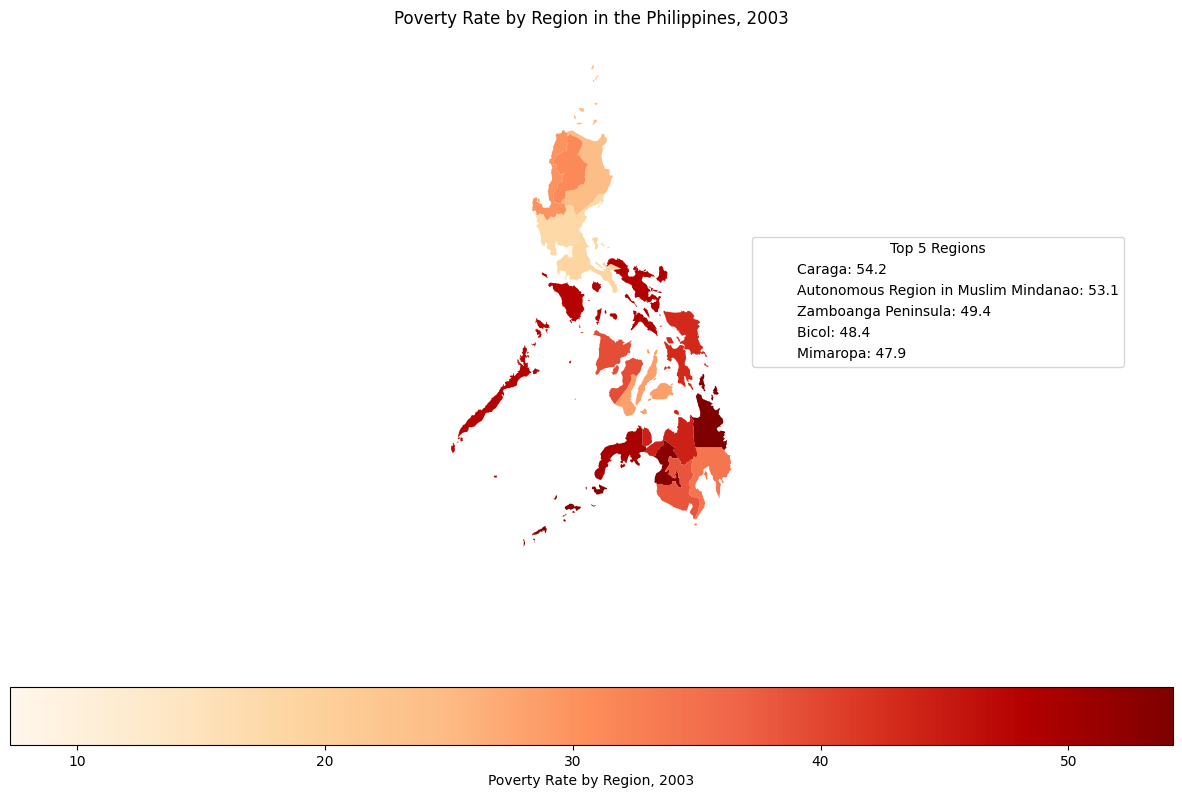

In [12]:
# Check for missing or infinite values in the '2003' column
print("Missing values in '2003':", gdf_regions['2003'].isnull().sum())
print("Finite values in '2003':", np.isfinite(gdf_regions['2003']).sum())

# Handle missing or infinite values
gdf_regions = gdf_regions.replace([np.inf, -np.inf], np.nan).dropna(subset=['2003'])

# Identify the top 5 regions with the highest poverty rates in 2003
top_5_regions = gdf_regions.nlargest(5, '2003')

# Plot the geospatial visualization
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

gdf_regions.plot(column='2003', ax=ax, legend=True,
                 legend_kwds={'label': "Poverty Rate by Region, 2003",
                              'orientation': "horizontal"},
                 cmap='OrRd')

# Add title and remove axis
plt.title('Poverty Rate by Region in the Philippines, 2003')
ax.set_axis_off()

# Create custom legend entries for the top 5 regions
legend_entries = []
for idx, row in top_5_regions.iterrows():
    legend_entries.append(mpatches.Patch(color='none', label=f"{row['name']}: {row['2003']}"))

# Add the custom legend to the right of the plot
plt.legend(handles=legend_entries, loc='center left', bbox_to_anchor=(1, 0.5), title="Top 5 Regions")

# Show the plot
plt.show()

Missing values in '2006': 0
Finite values in '2006': 17


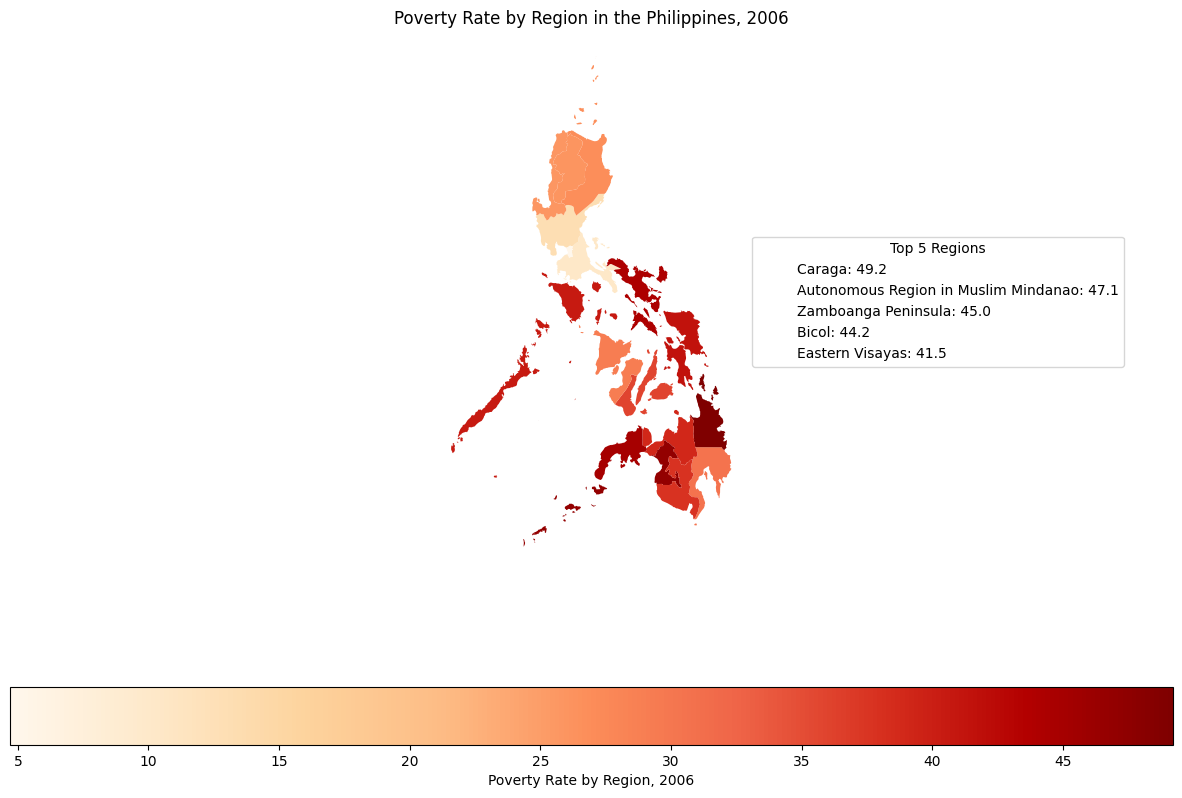

In [13]:
# Check for missing or infinite values in the '2006' column
print("Missing values in '2006':", gdf_regions['2006'].isnull().sum())
print("Finite values in '2006':", np.isfinite(gdf_regions['2006']).sum())

# Handle missing or infinite values
gdf_regions = gdf_regions.replace([np.inf, -np.inf], np.nan).dropna(subset=['2006'])

# Identify the top 5 regions with the highest poverty rates in 2006
top_5_regions = gdf_regions.nlargest(5, '2006')

# Plot the geospatial visualization
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

gdf_regions.plot(column='2006', ax=ax, legend=True,
                 legend_kwds={'label': "Poverty Rate by Region, 2006",
                              'orientation': "horizontal"},
                 cmap='OrRd')

# Add title and remove axis
plt.title('Poverty Rate by Region in the Philippines, 2006')
ax.set_axis_off()

# Create custom legend entries for the top 5 regions
legend_entries = []
for idx, row in top_5_regions.iterrows():
    legend_entries.append(mpatches.Patch(color='none', label=f"{row['name']}: {row['2006']}"))

# Add the custom legend to the right of the plot
plt.legend(handles=legend_entries, loc='center left', bbox_to_anchor=(1, 0.5), title="Top 5 Regions")

# Show the plot
plt.show()

Missing values in '2009': 0
Finite values in '2009': 17


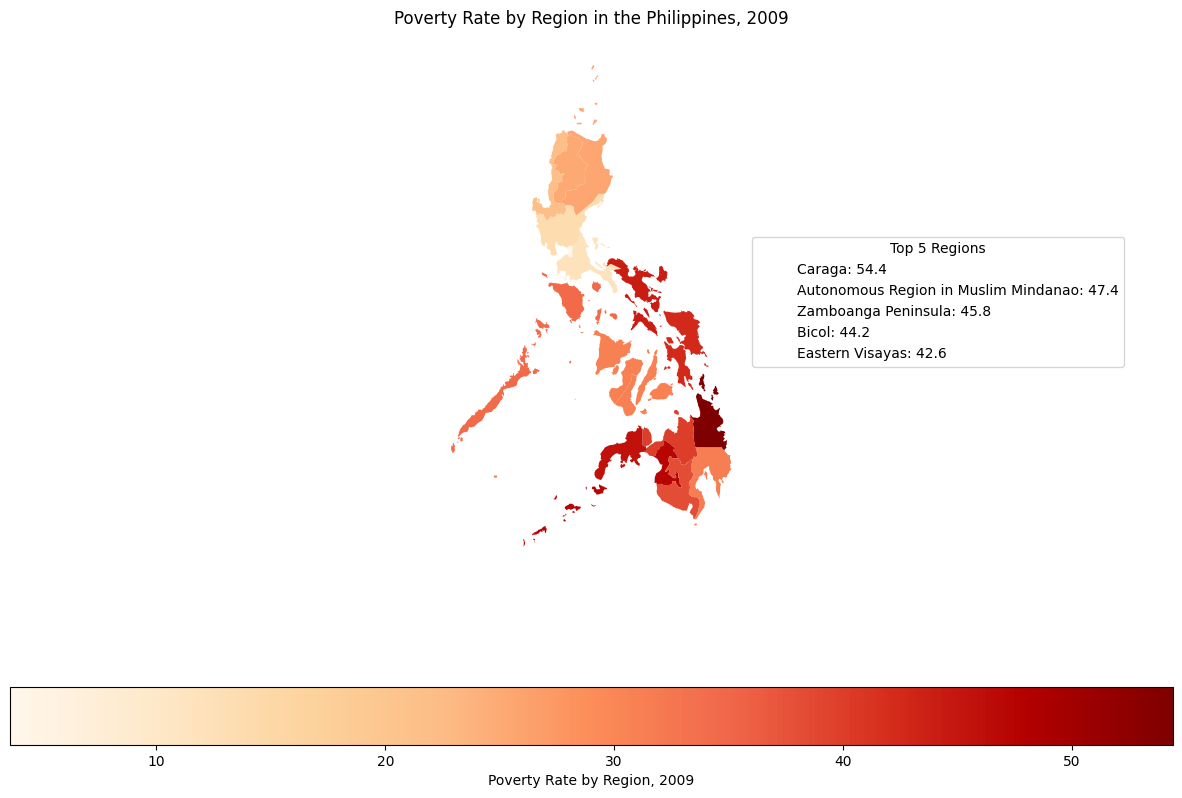

In [14]:
# Check for missing or infinite values in the '2009' column
print("Missing values in '2009':", gdf_regions['2009'].isnull().sum())
print("Finite values in '2009':", np.isfinite(gdf_regions['2009']).sum())

# Handle missing or infinite values
gdf_regions = gdf_regions.replace([np.inf, -np.inf], np.nan).dropna(subset=['2009'])

# Identify the top 5 regions with the highest poverty rates in 2009
top_5_regions = gdf_regions.nlargest(5, '2009')

# Plot the geospatial visualization
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

gdf_regions.plot(column='2009', ax=ax, legend=True,
                 legend_kwds={'label': "Poverty Rate by Region, 2009",
                              'orientation': "horizontal"},
                 cmap='OrRd')

# Add title and remove axis
plt.title('Poverty Rate by Region in the Philippines, 2009')
ax.set_axis_off()

# Create custom legend entries for the top 5 regions
legend_entries = []
for idx, row in top_5_regions.iterrows():
    legend_entries.append(mpatches.Patch(color='none', label=f"{row['name']}: {row['2009']}"))

# Add the custom legend to the right of the plot
plt.legend(handles=legend_entries, loc='center left', bbox_to_anchor=(1, 0.5), title="Top 5 Regions")

# Show the plot
plt.show()

Missing values in '2012': 0
Finite values in '2012': 17


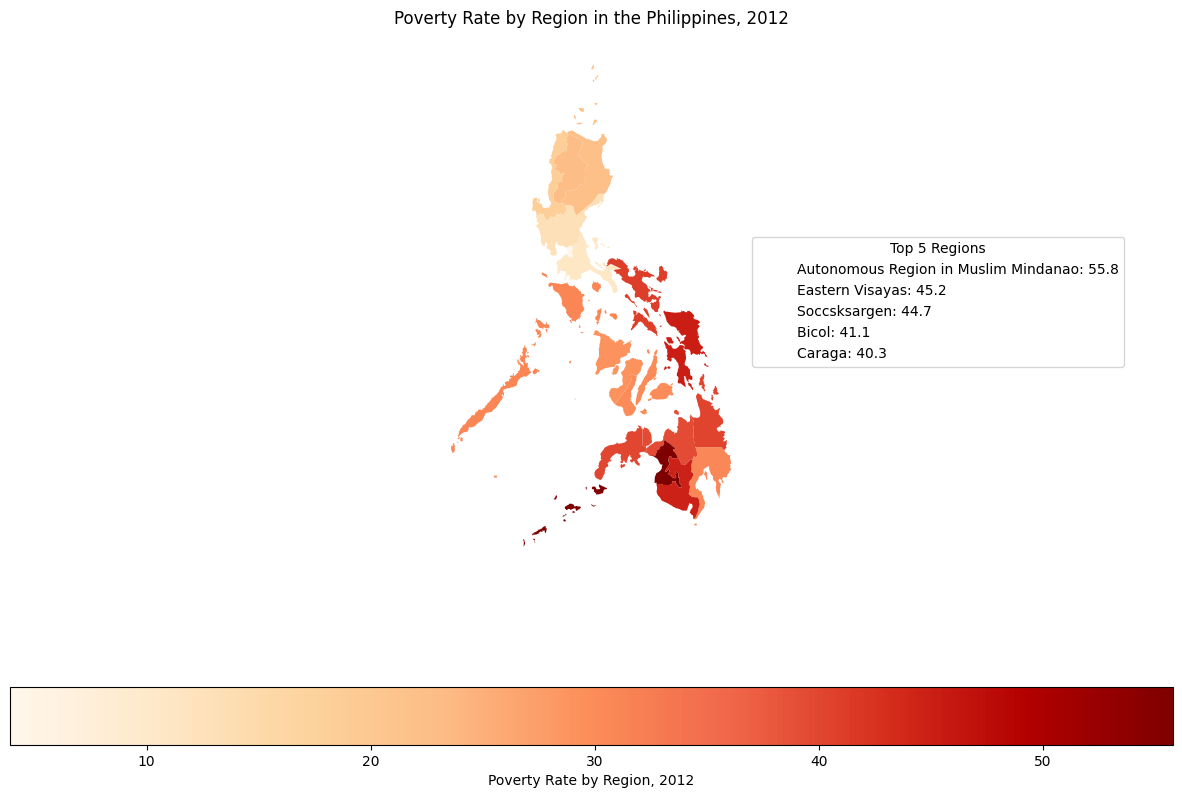

In [15]:
# Check for missing or infinite values in the '2012' column
print("Missing values in '2012':", gdf_regions['2012'].isnull().sum())
print("Finite values in '2012':", np.isfinite(gdf_regions['2012']).sum())

# Handle missing or infinite values
gdf_regions = gdf_regions.replace([np.inf, -np.inf], np.nan).dropna(subset=['2012'])

# Identify the top 5 regions with the highest poverty rates in 2012
top_5_regions = gdf_regions.nlargest(5, '2012')

# Plot the geospatial visualization
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

gdf_regions.plot(column='2012', ax=ax, legend=True,
                 legend_kwds={'label': "Poverty Rate by Region, 2012",
                              'orientation': "horizontal"},
                 cmap='OrRd')

# Add title and remove axis
plt.title('Poverty Rate by Region in the Philippines, 2012')
ax.set_axis_off()

# Create custom legend entries for the top 5 regions
legend_entries = []
for idx, row in top_5_regions.iterrows():
    legend_entries.append(mpatches.Patch(color='none', label=f"{row['name']}: {row['2012']}"))

# Add the custom legend to the right of the plot
plt.legend(handles=legend_entries, loc='center left', bbox_to_anchor=(1, 0.5), title="Top 5 Regions")

# Show the plot
plt.show()

Missing values in '2015': 0
Finite values in '2015': 17


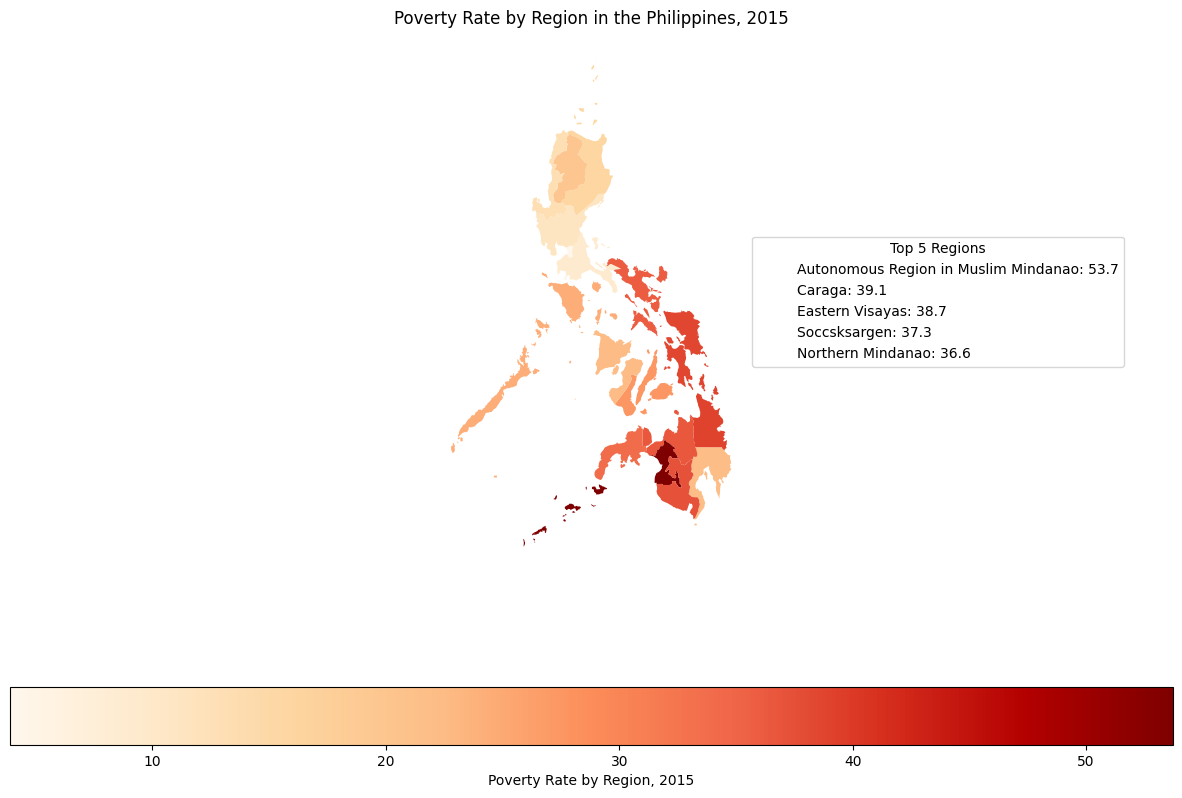

In [16]:
# Check for missing or infinite values in the '2015' column
print("Missing values in '2015':", gdf_regions['2015'].isnull().sum())
print("Finite values in '2015':", np.isfinite(gdf_regions['2015']).sum())

# Handle missing or infinite values
gdf_regions = gdf_regions.replace([np.inf, -np.inf], np.nan).dropna(subset=['2015'])

# Identify the top 5 regions with the highest poverty rates in 2015
top_5_regions = gdf_regions.nlargest(5, '2015')

# Plot the geospatial visualization
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

gdf_regions.plot(column='2015', ax=ax, legend=True,
                 legend_kwds={'label': "Poverty Rate by Region, 2015",
                              'orientation': "horizontal"},
                 cmap='OrRd')

# Add title and remove axis
plt.title('Poverty Rate by Region in the Philippines, 2015')
ax.set_axis_off()

# Create custom legend entries for the top 5 regions
legend_entries = []
for idx, row in top_5_regions.iterrows():
    legend_entries.append(mpatches.Patch(color='none', label=f"{row['name']}: {row['2015']}"))

# Add the custom legend to the right of the plot
plt.legend(handles=legend_entries, loc='center left', bbox_to_anchor=(1, 0.5), title="Top 5 Regions")

# Show the plot
plt.show()

Missing values in '2018': 0
Finite values in '2018': 17


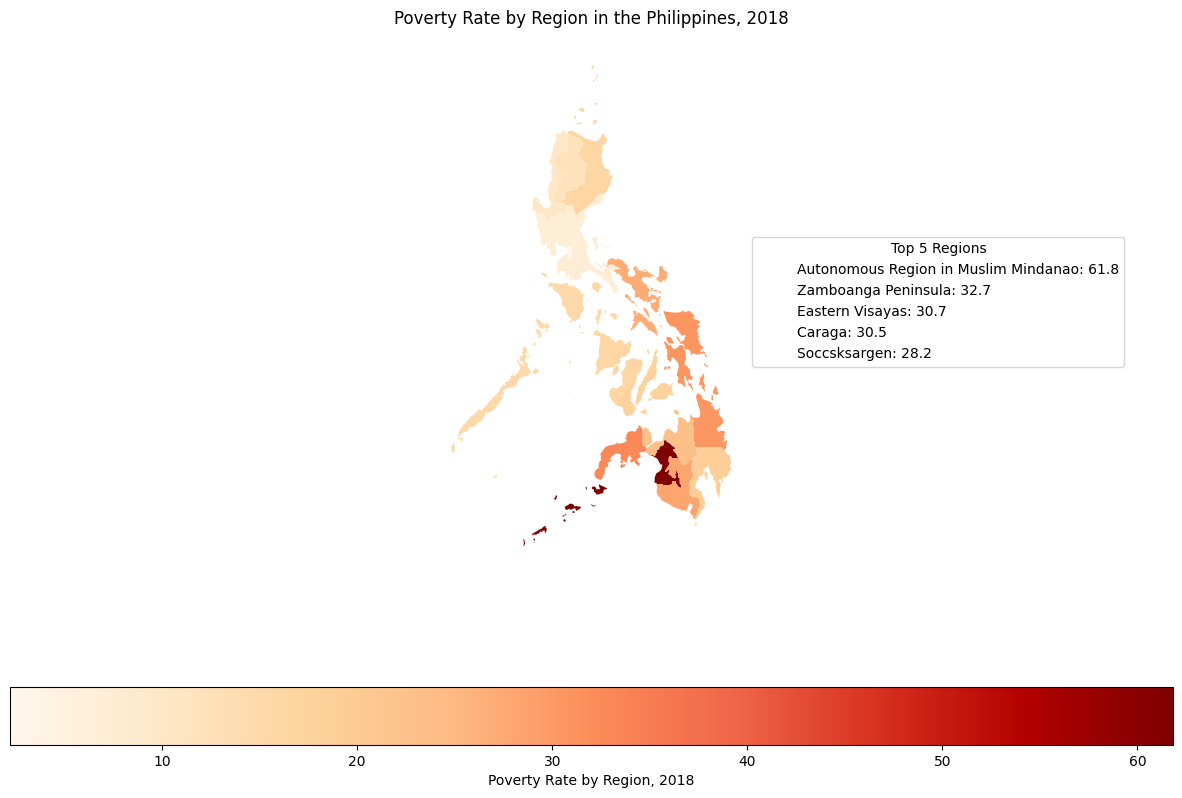

In [17]:
# Check for missing or infinite values in the '2018' column
print("Missing values in '2018':", gdf_regions['2018'].isnull().sum())
print("Finite values in '2018':", np.isfinite(gdf_regions['2018']).sum())

# Handle missing or infinite values
gdf_regions = gdf_regions.replace([np.inf, -np.inf], np.nan).dropna(subset=['2018'])

# Identify the top 5 regions with the highest poverty rates in 2018
top_5_regions = gdf_regions.nlargest(5, '2018')

# Plot the geospatial visualization
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

gdf_regions.plot(column='2018', ax=ax, legend=True,
                 legend_kwds={'label': "Poverty Rate by Region, 2018",
                              'orientation': "horizontal"},
                 cmap='OrRd')

# Add title and remove axis
plt.title('Poverty Rate by Region in the Philippines, 2018')
ax.set_axis_off()

# Create custom legend entries for the top 5 regions
legend_entries = []
for idx, row in top_5_regions.iterrows():
    legend_entries.append(mpatches.Patch(color='none', label=f"{row['name']}: {row['2018']}"))

# Add the custom legend to the right of the plot
plt.legend(handles=legend_entries, loc='center left', bbox_to_anchor=(1, 0.5), title="Top 5 Regions")

# Show the plot
plt.show()

Missing values in '2021': 0
Finite values in '2021': 17


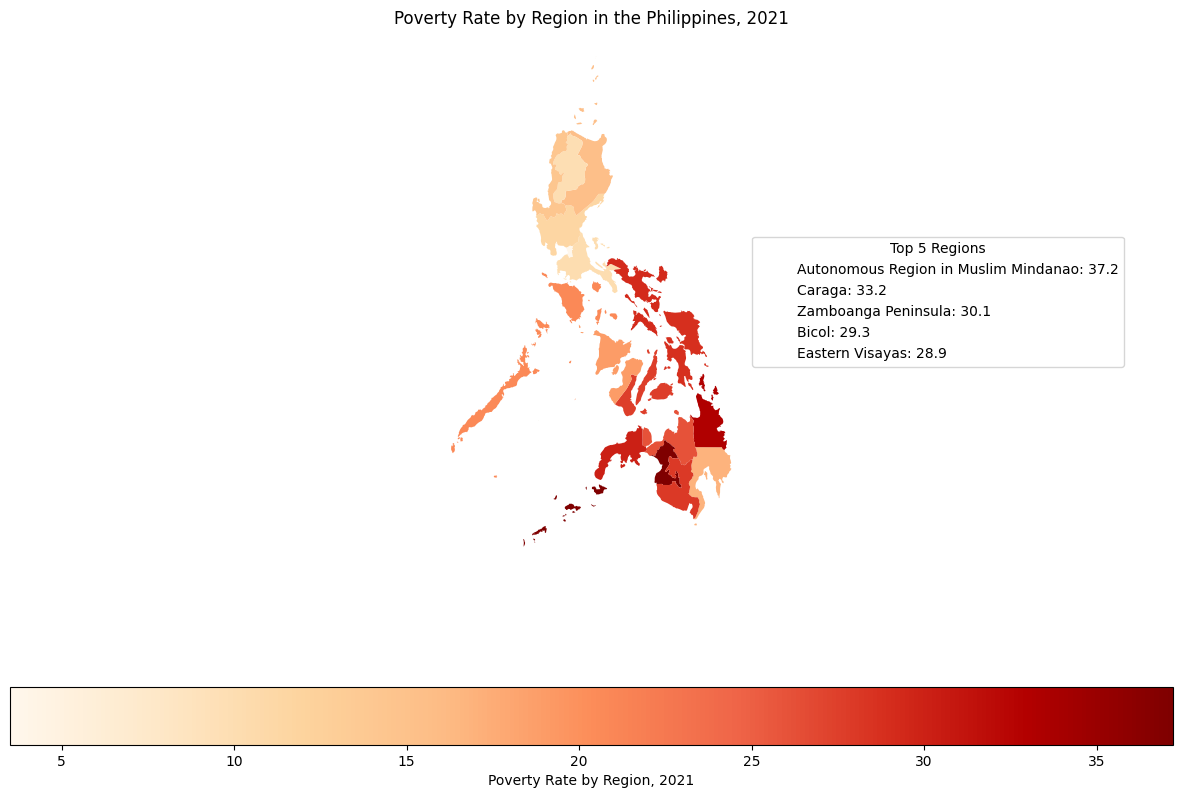

In [18]:
# Check for missing or infinite values in the '2021' column
print("Missing values in '2021':", gdf_regions['2021'].isnull().sum())
print("Finite values in '2021':", np.isfinite(gdf_regions['2021']).sum())

# Handle missing or infinite values
gdf_regions = gdf_regions.replace([np.inf, -np.inf], np.nan).dropna(subset=['2021'])

# Identify the top 5 regions with the highest poverty rates in 2021
top_5_regions = gdf_regions.nlargest(5, '2021')

# Plot the geospatial visualization
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

gdf_regions.plot(column='2021', ax=ax, legend=True,
                 legend_kwds={'label': "Poverty Rate by Region, 2021",
                              'orientation': "horizontal"},
                 cmap='OrRd')

# Add title and remove axis
plt.title('Poverty Rate by Region in the Philippines, 2021')
ax.set_axis_off()

# Create custom legend entries for the top 5 regions
legend_entries = []
for idx, row in top_5_regions.iterrows():
    legend_entries.append(mpatches.Patch(color='none', label=f"{row['name']}: {row['2021']}"))

# Add the custom legend to the right of the plot
plt.legend(handles=legend_entries, loc='center left', bbox_to_anchor=(1, 0.5), title="Top 5 Regions")

# Show the plot
plt.show()

## Regression Analysis

In [19]:
# Load datasets
df_political = pd.read_excel("ASOG.xlsx")  # Fat dynasty data
df_poverty = pd.read_csv("philippines-poverty-rate.csv")  # Poverty data

# Create a unique identifier for individuals (optional, but helpful)
df_political['Full_Name'] = df_political['First Name'] + " " + df_political['Last Name']

# Example filters (adjust these based on your dataset)
df_political = df_political.dropna(subset=['Province', 'First Name', 'Last Name'])  # Drop rows with missing values

print(df_political)
print(df_poverty)

          First Name Last Name        Party  \
0              BAMER       AAD        KAMPI   
1               AMIN     AADAM  INDEPENDENT   
2               AMIN     AADAM    LAKAS-CMD   
3      TRISTAN ROYCE      AALA         IND.   
4      SHIRLEY BELEN      AALA    LAKAS-CMD   
...              ...       ...          ...   
86229         SERGIO    ZURITA        BAKUD   
86230       AUGUSTOS    ZURITA        BAKUD   
86231       AUGUSTOS    ZURITA        BAKUD   
86232       AUGUSTOS    ZURITA         IND.   
86233         SERGIO    ZURITA          NPC   

                                     Region         Province  \
0      Autonomous Region in Muslim Mindanao    LANAO DEL SUR   
1      Autonomous Region in Muslim Mindanao    LANAO DEL SUR   
2      Autonomous Region in Muslim Mindanao    LANAO DEL SUR   
3                                 REGION XI  DAVAO DEL NORTE   
4                                 REGION XI  DAVAO DEL NORTE   
...                                     ...        

In [20]:
print(df_political.groupby(['Region', 'Year']).size())

Region                                Year
Autonomous Region in Muslim Mindanao  2004     999
                                      2007     851
                                      2010    1084
                                      2013    1009
                                      2016    1133
                                              ... 
REGION XIII                           2004     791
                                      2007     732
                                      2010     809
                                      2013     798
                                      2016     797
Length: 85, dtype: int64


In [21]:
print(df_political['fat'].value_counts())

fat
0    63229
1    23005
Name: count, dtype: int64


In [22]:
# Replace common discrepancies
df_political['Region'] = df_political['Region'].replace({'Autonomous Region in Muslim Mindanao': 'ARMM'})
df_political['Region'] = df_political['Region'].replace({'CORDILLERA ADMINISTRATIVE REGION': 'CAR'})
df_political['Region'] = df_political['Region'].replace({'NATIONAL CAPITAL REGION': 'NCR'})

In [23]:
df_poverty['Region'] = df_poverty['Region'].replace({'Autonomous Region in Muslim Mindanao': 'ARMM'})
df_poverty['Region'] = df_poverty['Region'].replace({'CORDILLERA ADMINISTRATIVE REGION': 'CAR'})
df_poverty['Region'] = df_poverty['Region'].replace({'NATIONAL CAPITAL REGION': 'NCR'})

In [24]:
print(df_political['Region'].unique())
print(df_poverty['Region'].unique())

['ARMM' 'REGION XI' 'REGION IV-A' 'REGION VII' 'REGION I' 'REGION V'
 'REGION III' 'REGION II' 'REGION IX' 'REGION VIII' 'REGION X' 'CAR'
 'REGION IV-B' 'REGION VI' 'REGION XII' 'NCR' 'REGION XIII']
['Philippines' 'NCR' 'CAR' 'REGION I' 'REGION II' 'REGION III'
 'REGION IV-A' 'REGION IV-B' 'REGION V' 'REGION VI' 'REGION VII'
 'REGION VIII' 'REGION IX' 'REGION X' 'REGION XI' 'REGION XII'
 'REGION XIII' 'ARMM']


In [25]:
df_poverty_long = pd.melt(df_poverty, 
                            id_vars=['Region'], 
                            var_name='Year', 
                            value_name='poverty')

# Convert 'Year' to integers and shift by +1
df_poverty_long['Year'] = df_poverty_long['Year'].astype(int) + 1

# Display reshaped poverty data
print(df_poverty_long)

          Region  Year  poverty
0    Philippines  2004     30.4
1            NCR  2004      7.3
2            CAR  2004     31.2
3       REGION I  2004     30.2
4      REGION II  2004     24.5
..           ...   ...      ...
121     REGION X  2022     26.1
122    REGION XI  2022     16.8
123   REGION XII  2022     28.1
124  REGION XIII  2022     33.2
125         ARMM  2022     37.2

[126 rows x 3 columns]


In [26]:
# Standardize region names for consistency
df_political['Region'] = df_political['Region'].str.strip().str.upper()
df_poverty_long['Region'] = df_poverty_long['Region'].str.strip().str.upper()
print(df_political['Region'])
print(df_poverty_long['Region'])

0              ARMM
1              ARMM
2              ARMM
3         REGION XI
4         REGION XI
            ...    
86229    REGION VII
86230    REGION VII
86231    REGION VII
86232    REGION VII
86233    REGION VII
Name: Region, Length: 86234, dtype: object
0      PHILIPPINES
1              NCR
2              CAR
3         REGION I
4        REGION II
          ...     
121       REGION X
122      REGION XI
123     REGION XII
124    REGION XIII
125           ARMM
Name: Region, Length: 126, dtype: object


In [27]:
df_political_filtered = df_political[['Region', 'Year', 'fat']]
df_poverty_filtered = df_poverty_long[['Region', 'Year', 'poverty']]

In [28]:
# Merge the two datasets on 'Region' and 'Year'
merged_data = pd.merge(df_political_filtered, df_poverty_filtered, on=['Region', 'Year'], how='inner')

# Verify the structure of the merged data
print(merged_data.shape)
print(merged_data.info())

(86234, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86234 entries, 0 to 86233
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Region   86234 non-null  object 
 1   Year     86234 non-null  int64  
 2   fat      86234 non-null  int64  
 3   poverty  86234 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.6+ MB
None


In [29]:
# Only drop rows where critical data is missing
merged_data.dropna(subset=['poverty', 'fat', 'Year', 'Region'], inplace=True)

# Ensure 'year' and 'fat' are properly converted
merged_data['Year'] = pd.to_numeric(merged_data['Year'], errors='coerce')
merged_data['fat'] = pd.to_numeric(merged_data['fat'], errors='coerce')

# Recheck for NaNs after conversion
merged_data.dropna(inplace=True)

# Encode 'Region' as categorical
merged_data['region_code'] = merged_data['Region'].astype('category').cat.codes

# Add constant for the intercept
merged_data['constant'] = 1

In [30]:
print(merged_data.shape)
print(merged_data.head())

(86234, 6)
      Region  Year  fat  poverty  region_code  constant
0       ARMM  2007    0     47.1            0         1
1       ARMM  2004    0     53.1            0         1
2       ARMM  2007    0     47.1            0         1
3  REGION XI  2010    1     31.4           14         1
4  REGION XI  2004    1     34.4           14         1


In [31]:
# Summary statistics for 'poverty'
summary_stats = merged_data['poverty'].describe()
print(summary_stats)

count    86234.000000
mean        31.152414
std         13.014462
min          3.600000
25%         22.000000
50%         31.000000
75%         41.100000
max         55.800000
Name: poverty, dtype: float64


In [32]:
# Transform 'poverty' to log form (handling zeros)
merged_data['log_poverty'] = np.log(merged_data['poverty'].replace(0, 0.0001))

In [33]:
print(merged_data['log_poverty'].unique())
print(merged_data['Year'].unique())
print(merged_data['fat'].unique())

[3.852273   3.97217693 3.44680789 3.53805656 2.93385687 2.3321439
 3.42426265 3.09104245 2.38876279 2.20827441 3.983413   3.85862223
 4.02177387 3.31781577 2.57261223 3.78872479 3.87949981 2.55722731
 2.41591378 2.61739583 2.87356464 3.4339872  3.25424297 3.5807373
 3.34638915 3.40784192 3.19867312 3.28840189 3.23867845 3.09557761
 2.76000994 3.52341501 3.58351894 3.69137633 3.76815264 3.67630067
 3.60004824 3.66356165 3.71600812 3.72569343 3.6558396  2.91777073
 2.4765384  2.98061864 3.22286785 3.12676054 3.75185425 3.81109709
 3.70376807 3.54095932 3.66612247 3.89995042 3.82428409 3.10906096
 3.63495111 1.36097655 1.98787435 1.54756251 1.28093385 3.6454499
 3.19458313 3.64805746 3.61899333 3.7999735  3.99636415 3.99268091
 3.89589362 3.79098468 3.8691155  3.37073817 3.80666249 3.25809654
 3.69635147 3.44041809 3.42751469 3.42100001]
[2007 2004 2010 2013 2016]
[0 1]


In [34]:
print(merged_data['fat'])

0        0
1        0
2        0
3        1
4        1
        ..
86229    0
86230    0
86231    0
86232    0
86233    0
Name: fat, Length: 86234, dtype: int64


In [35]:
print(merged_data['Region'].unique())

['ARMM' 'REGION XI' 'REGION IV-A' 'REGION VII' 'REGION I' 'REGION V'
 'REGION III' 'REGION II' 'REGION IX' 'REGION VIII' 'REGION X' 'CAR'
 'REGION IV-B' 'REGION VI' 'REGION XII' 'NCR' 'REGION XIII']


In [36]:
region_mapping = {
    0: "NCR",
    1: "CAR",
    2: "REGION I",
    3: "REGION II",
    4: "REGION III",
    5: "REGION IV-A",
    6: "REGION IV-B",
    7: "REGION V",
    8: "REGION VI",
    9: "REGION VII",
    10: "REGION VIII",
    11: "REGION IX",
    12: "REGION X",
    13: "REGION XI",
    14: "REGION XII",
    15: "REGION XIII",
    16: "ARMM"
}

In [37]:
merged_data['Region_Code'] = merged_data['Region'].map({v: k for k, v in region_mapping.items()})

In [38]:
print(region_mapping)

{0: 'NCR', 1: 'CAR', 2: 'REGION I', 3: 'REGION II', 4: 'REGION III', 5: 'REGION IV-A', 6: 'REGION IV-B', 7: 'REGION V', 8: 'REGION VI', 9: 'REGION VII', 10: 'REGION VIII', 11: 'REGION IX', 12: 'REGION X', 13: 'REGION XI', 14: 'REGION XII', 15: 'REGION XIII', 16: 'ARMM'}


In [39]:
# Set 'NATIONAL CAPITAL REGION' (NCR) as the base Region
merged_data['Region'] = pd.Categorical(
    merged_data['Region'], 
    categories=[
        'NCR', 
        'CAR', 'REGION I', 'REGION II',
        'REGION III', 'REGION IV-A', 'REGION IV-B', 'REGION V',
        'REGION VI', 'REGION VII', 'REGION VIII', 'REGION IX',
        'REGION X', 'REGION XI', 'REGION XII', 'REGION XIII',
        'ARMM'
    ],
    ordered=True
)

# Set '2004' as the base Year
merged_data['Year'] = pd.Categorical(merged_data['Year'], 
                                     categories=[2004, 2007, 2010, 2013, 2016], 
                                     ordered=True)

##### Simple OLS Regression

In [40]:
# Run the regression
model = smf.ols('log_poverty ~ fat + C(Region) + C(Year)', data=merged_data).fit()

# Display the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            log_poverty   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                 9.579e+04
Date:                Mon, 07 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:33:14   Log-Likelihood:                 68786.
No. Observations:               86234   AIC:                        -1.375e+05
Df Residuals:                   86212   BIC:                        -1.373e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [41]:
import statsmodels.stats.api as sms
_, pval, __, f_pval = sms.het_breuschpagan(model.resid, model.model.exog)
print(f'Breusch-Pagan p-value: {pval:.4f}')

Breusch-Pagan p-value: 0.0000


In [42]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="linearmodels")

##### Fixed Effects

In [43]:
# Create a copy of merged_data with the relevant columns
new_data = merged_data[['Region', 'Year', 'log_poverty', 'fat']].copy()

# Ensure 'Year' is numeric
new_data['Year'] = pd.to_numeric(new_data['Year'], errors='coerce')

# Create a MultiIndex for the new data object
new_data = new_data.set_index(['Region', 'Year'])

# Run the Fixed Effects Regression
model = PanelOLS.from_formula('log_poverty ~ fat + EntityEffects + TimeEffects', data=new_data)
fe_results = model.fit()

# Step 5: Display the Results
print(fe_results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:            log_poverty   R-squared:                     6.541e-06
Estimator:                   PanelOLS   R-squared (Between):           9.429e-05
No. Observations:               86234   R-squared (Within):           -7.523e-05
Date:                Mon, Apr 07 2025   R-squared (Overall):           9.834e-05
Time:                        15:33:15   Log-likelihood                 6.879e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.5639
Entities:                          17   P-value                           0.4527
Avg Obs:                       5072.6   Distribution:                 F(1,86212)
Min Obs:                       1627.0                                           
Max Obs:                       7438.0   F-statistic (robust):             0.5639
                            

##### Random Effects

In [44]:
# Random effects
# Prepare the panel data structure
test_data = merged_data[['log_poverty', 'fat', 'Region', 'Year']].copy()

# Ensure 'Year' is numeric or categorical, as needed
test_data['Year'] = test_data['Year'].astype(int)  # Convert Year to numeric

# Reset index to create dummy variables properly
test_data = test_data.reset_index()

# Create dummy variables for Year
year_dummies = pd.get_dummies(test_data['Year'], prefix='Year', drop_first=True)

# Set the panel multi-index again
test_data = test_data.set_index(['Region', 'Year'])
# Make sure dummy variables align with test_data index
year_dummies.index = test_data.index  # Explicitly assign the same index

In [45]:
print(test_data.index)  # Should show a MultiIndex with levels: 'Region' and 'Year'

MultiIndex([(       'ARMM', 2007),
            (       'ARMM', 2004),
            (       'ARMM', 2007),
            (  'REGION XI', 2010),
            (  'REGION XI', 2004),
            (  'REGION XI', 2004),
            ('REGION IV-A', 2004),
            ('REGION IV-A', 2007),
            (  'REGION XI', 2013),
            (  'REGION XI', 2013),
            ...
            (   'REGION V', 2007),
            (   'REGION V', 2004),
            (   'REGION V', 2016),
            ( 'REGION VII', 2013),
            (  'REGION II', 2016),
            ( 'REGION VII', 2007),
            ( 'REGION VII', 2013),
            ( 'REGION VII', 2016),
            ( 'REGION VII', 2010),
            ( 'REGION VII', 2004)],
           names=['Region', 'Year'], length=86234)


In [46]:
# Independent variables (fat, year dummies)
x = pd.concat([test_data[['fat']], year_dummies], axis=1)

# Dependent variable
y = test_data['log_poverty']

# Add a constant term
x = sm.add_constant(x)

# Fit the Random Effects model
re_model = RandomEffects(y, x).fit()

# Print the model summary
print(re_model.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:            log_poverty   R-squared:                        0.5686
Estimator:              RandomEffects   R-squared (Between):              0.0012
No. Observations:               86234   R-squared (Within):               0.5687
Date:                Mon, Apr 07 2025   R-squared (Overall):              0.0528
Time:                        15:33:15   Log-likelihood                 6.875e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   2.273e+04
Entities:                          17   P-value                           0.0000
Avg Obs:                       5072.6   Distribution:                 F(5,86228)
Min Obs:                       1627.0                                           
Max Obs:                       7438.0   F-statistic (robust):          2.273e+04
                            

In [47]:
# Hausman Test
from linearmodels.panel import compare
import scipy.stats as stats

# Fit both models correctly and retain the result objects
fe_model = PanelOLS.from_formula('log_poverty ~ fat + EntityEffects + TimeEffects', data=new_data)
fe_results = fe_model.fit()

re_model = RandomEffects.from_formula('log_poverty ~ fat', data=new_data)
re_results = re_model.fit()

# Now compare the model **results**
comparison = compare({"Fixed Effects": fe_results, "Random Effects": re_results})
print(comparison)

# Extract coefficient estimates (excluding the constant term)
b_fe = fe_results.params.drop('Intercept', errors='ignore')
b_re = re_results.params.drop('Intercept', errors='ignore')

# Extract covariance matrices
v_fe = fe_results.cov.loc[b_fe.index, b_fe.index]
v_re = re_results.cov.loc[b_re.index, b_re.index]

# Compute the difference in coefficients
beta_diff = b_fe - b_re

# Compute the variance difference
var_diff = v_fe - v_re

# Check if var_diff is invertible
if np.linalg.det(var_diff) == 0:
    print("Warning: Variance matrix is singular. Using pseudo-inverse.")
    var_diff_inv = np.linalg.pinv(var_diff)  # Use pseudo-inverse
else:
    var_diff_inv = np.linalg.inv(var_diff)

# Compute the test statistic
hausman_stat = beta_diff.T @ var_diff_inv @ beta_diff

# Get degrees of freedom (number of independent variables)
df = len(beta_diff)

# Compute p-value
p_value = 1 - stats.chi2.cdf(hausman_stat, df)

# Print results
print(f"Hausman Test Statistic: {hausman_stat:.4f}")
print(f"Degrees of Freedom: {df}")
print(f"P-Value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("Reject Null Hypothesis: FE model is preferred (Endogeneity is present).")
else:
    print("Fail to Reject Null Hypothesis: RE model is preferred (No endogeneity detected).")

                     Model Comparison                    
                          Fixed Effects    Random Effects
---------------------------------------------------------
Dep. Variable               log_poverty       log_poverty
Estimator                      PanelOLS     RandomEffects
No. Observations                  86234             86234
Cov. Est.                    Unadjusted        Unadjusted
R-squared                     6.541e-06            0.0005
R-Squared (Within)           -7.523e-05            0.0005
R-Squared (Between)           9.429e-05           -0.0012
R-Squared (Overall)           9.834e-05           -0.0013
F-statistic                      0.5639            39.742
P-value (F-stat)                 0.4527            0.0000
=====================     =============   ===============
fat                              0.0006           -0.0081
                               (0.7510)         (-6.3042)
======================= =============== =================
Effects       

##### OLS Regression with Robust Error 

In [48]:
#robust error
model_robust = smf.ols('log_poverty ~ C(Region) + C(Year) + fat', data=merged_data).fit(cov_type='HC3')
print(model_robust.summary())

                            OLS Regression Results                            
Dep. Variable:            log_poverty   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                 2.264e+05
Date:                Mon, 07 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:33:16   Log-Likelihood:                 68786.
No. Observations:               86234   AIC:                        -1.375e+05
Df Residuals:                   86212   BIC:                        -1.373e+05
Df Model:                          21                                         
Covariance Type:                  HC3                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

##### Logit

In [49]:
# Logit Regression
logit_model = smf.logit('fat ~ log_poverty + C(Region) + C(Year)', data=merged_data).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.571036
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                    fat   No. Observations:                86234
Model:                          Logit   Df Residuals:                    86212
Method:                           MLE   Df Model:                           21
Date:                Mon, 07 Apr 2025   Pseudo R-squ.:                 0.01550
Time:                        15:33:17   Log-Likelihood:                -49243.
converged:                       True   LL-Null:                       -50018.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.3451      0.132    -10.189      0.000      -1.604

##### Probit

In [50]:
# Probit Regression
probit_model = smf.probit('fat ~ log_poverty + C(Region) + C(Year)', data=merged_data).fit()
print(probit_model.summary())

Optimization terminated successfully.
         Current function value: 0.571029
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:                    fat   No. Observations:                86234
Model:                         Probit   Df Residuals:                    86212
Method:                           MLE   Df Model:                           21
Date:                Mon, 07 Apr 2025   Pseudo R-squ.:                 0.01551
Time:                        15:33:18   Log-Likelihood:                -49242.
converged:                       True   LL-Null:                       -50018.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.8178      0.079    -10.390      0.000      -0.972

In [51]:
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(merged_data[merged_data['fat'] == 0]['log_poverty'],
                            merged_data[merged_data['fat'] == 1]['log_poverty'])
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 13.425204852177885, P-value: 4.733273229821219e-41


A t-statistic of 13.43 and a p-value of approximately 4.73e-41 indicate that the difference in means between the two groups (fat = 0 and fat = 1) is highly statistically significant. In simpler terms, there is strong evidence that the difference in log_poverty between these two groups is unlikely to have occurred by random chance.

Even though the difference is statistically significant, it doesn’t necessarily mean that the effect size (the magnitude of the difference) is practically meaningful. Recall that the difference in mean log_poverty between the two groups was fairly small (3.335 vs. 3.280). This could explain why fat remains statistically insignificant in the regression model—its contribution to explaining the variance in log_poverty might still be negligible when accounting for all other variables.

##### Interaction Effects

In [52]:
from statsmodels.formula.api import ols
#Check for Interaction Effects
model = ols('log_poverty ~ C(Year) + C(Region) + fat + C(Region):fat', data=merged_data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            log_poverty   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                 5.444e+04
Date:                Mon, 07 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:33:19   Log-Likelihood:                 68850.
No. Observations:               86234   AIC:                        -1.376e+05
Df Residuals:                   86196   BIC:                        -1.373e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

The coefficient for fat is 0.0230, and it is statistically significant (p-value = 0.000). This suggests that, on average, when fat = 1, log_poverty increases slightly by 0.0230 units, holding other factors constant.

However, the magnitude of this effect is still quite small, making its practical impact limited even though it is statistically significant.

The interaction terms (e.g., C(Region)[T.REGION I]:fat) capture how the effect of fat varies across regions. Most of these interaction terms are negative and statistically significant, indicating that in some regions, the increase in log_poverty associated with fat = 1 is smaller (or even reversed) compared to the baseline (e.g., the reference region).

For instance:

In Cordillera Administrative Region, the interaction term for fat is -0.0266. This means that the overall effect of fat in this region is approximately 0.0230 - 0.0266 = -0.0036, a negligible or slightly negative association.

Similarly, in National Capital Region, the interaction term is -0.0478, implying a weaker positive or even negative effect.

One interaction term stands out: C(Region)[T.REGION XII]:fat has a p-value = 0.829, meaning it is not statistically significant. This suggests that in Region XII, there is no significant deviation in the effect of fat compared to the baseline.

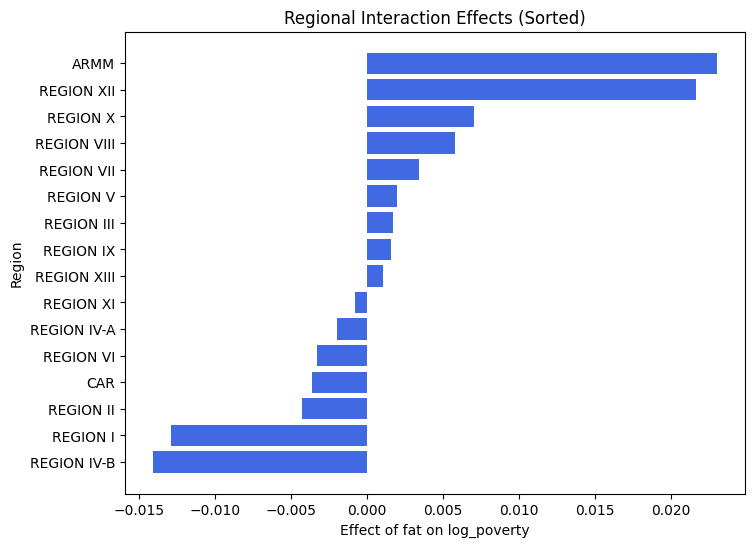

In [53]:
# Extract region names and their corresponding effects
regions = [region for region in merged_data['Region'].unique() if f"C(Region)[T.{region}]:fat" in model.params.index]
effects = [model.params["fat"] + model.params[f"C(Region)[T.{region}]:fat"] for region in regions]

# Sort regions and effects in descending order
sorted_regions, sorted_effects = zip(*sorted(zip(regions, effects), key=lambda x: x[1], reverse=True))

# Plot the sorted bar chart
plt.figure(figsize=(8, 6))
plt.barh(sorted_regions, sorted_effects, color='royalblue')
plt.xlabel('Effect of fat on log_poverty')
plt.ylabel('Region')
plt.title('Regional Interaction Effects (Sorted)')
plt.gca().invert_yaxis()  # Ensure highest effect is at the top
plt.show()

##### Difference-in-Difference

In [54]:
#DID
# Assume 'Post' is already created (1 for post-treatment period, 0 for pre-treatment).
merged_data['Post'] = merged_data['Year'].apply(lambda x: 1 if x >= 2007 else 0)  # Adjust based on your context

# Difference-in-Differences regression
did_model = smf.ols('log_poverty ~ fat + Post + fat:Post + C(Year) + C(Region)', data=merged_data).fit()
print(did_model.summary())


                            OLS Regression Results                            
Dep. Variable:            log_poverty   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                 8.747e+04
Date:                Mon, 07 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:33:19   Log-Likelihood:                 68790.
No. Observations:               86234   AIC:                        -1.375e+05
Df Residuals:                   86210   BIC:                        -1.373e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

The coefficient of fat:Post is -0.0064, and it is statistically significant (p-value = 0.003). This suggests that, after the introduction of the treatment (Post), the effect of fat reduced poverty logarithmically by -0.0064 units on average, holding all other variables constant.

The negative sign indicates a slight reduction in poverty levels associated with the treatment, but the effect size is relatively small.

The coefficient for fat remains 0.0058, which is statistically significant (p-value = 0.003). This reflects the baseline (pre-treatment) impact of fat on log_poverty.

The coefficient for Post (3.624e+09) appears highly inflated and is statistically insignificant (p-value = 0.368). This might indicate issues with scaling or multicollinearity between Post and other predictors.

The extremely large condition number (Cond. No. = 3.51e+13) and small eigenvalue in the notes suggest strong multicollinearity or that the design matrix is close to singular. This could distort coefficient estimates and statistical inference.

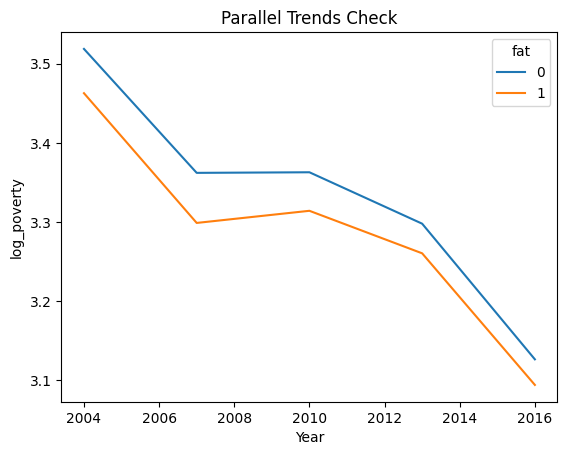

In [55]:
sns.lineplot(data=merged_data, x='Year', y='log_poverty', hue='fat', errorbar=None)  
plt.title('Parallel Trends Check')
plt.show()

In [56]:
#Consider robust standard errors to account for heteroskedasticity
did_model = smf.ols('log_poverty ~ fat + Post + fat:Post + C(Year) + C(Region)', data=merged_data).fit(cov_type='HC3')
print(did_model.summary())

                            OLS Regression Results                            
Dep. Variable:            log_poverty   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                    0.5317
Date:                Mon, 07 Apr 2025   Prob (F-statistic):              0.466
Time:                        15:33:20   Log-Likelihood:                 68790.
No. Observations:               86234   AIC:                        -1.375e+05
Df Residuals:                   86210   BIC:                        -1.373e+05
Df Model:                          23                                         
Covariance Type:                  HC3                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

D:\Programs\Anaconda\envs\Mechaela_econ\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 1
  warnings.warn('covariance of constraints does not have full '


##### Correlation of Variables

In [57]:
numeric_data = merged_data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_data.corr()
print(correlation_matrix)

                  fat   poverty  constant  log_poverty  Region_Code      Post
fat          1.000000 -0.043649       NaN    -0.045670    -0.020402  0.022907
poverty     -0.043649  1.000000       NaN     0.955977     0.752381 -0.179562
constant          NaN       NaN       NaN          NaN          NaN       NaN
log_poverty -0.045670  0.955977       NaN     1.000000     0.692513 -0.172270
Region_Code -0.020402  0.752381       NaN     0.692513     1.000000  0.000808
Post         0.022907 -0.179562       NaN    -0.172270     0.000808  1.000000


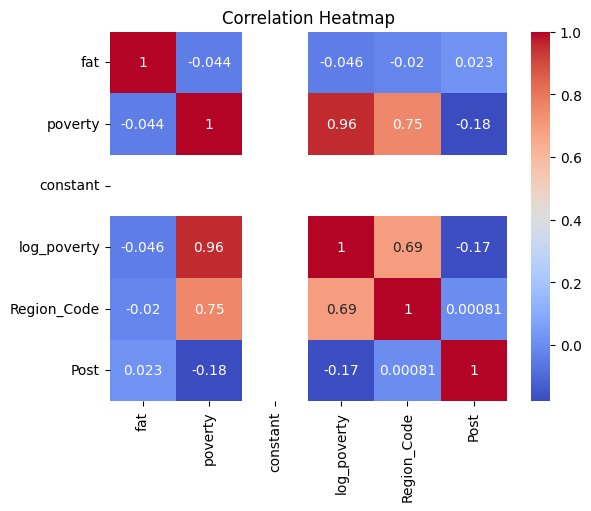

In [58]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

C:\Users\Elitedesk\AppData\Local\Temp\ipykernel_14496\4159961993.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_trends = merged_data.groupby(['Year', 'fat'])['log_poverty'].mean().reset_index()


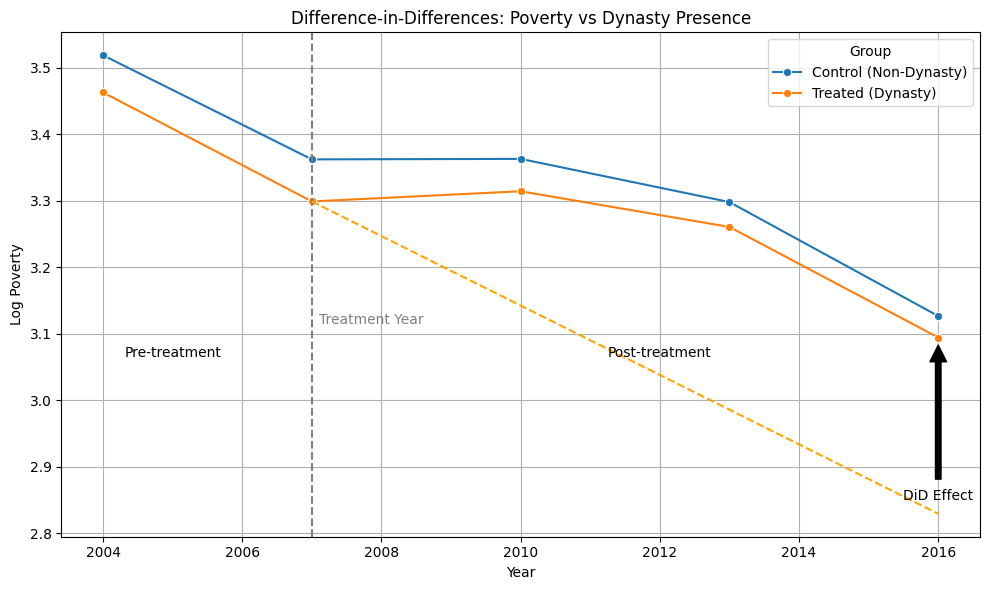

In [59]:
# Difference-in-Differences Estimation,  to visualize the parallel trends
# Whereas: Treated group (with political dynasty),Control group (no dynasty).

# First, compute average log_poverty by group and year
avg_trends = merged_data.groupby(['Year', 'fat'])['log_poverty'].mean().reset_index()
avg_trends['Group'] = avg_trends['fat'].map({1: 'Treated (Dynasty)', 0: 'Control (Non-Dynasty)'})

# Pivot for easier line drawing
pivot_df = avg_trends.pivot(index='Year', columns='Group', values='log_poverty')

plt.figure(figsize=(10,6))
sns.lineplot(data=avg_trends, x='Year', y='log_poverty', hue='Group', marker='o')

# Add vertical line (treatment year)
plt.axvline(x=2007, color='gray', linestyle='--')
plt.text(2007.1, pivot_df.min().min()+0.02, 'Treatment Year', color='gray')

# Add pre/post labels
plt.text(2005, pivot_df.min().min()-0.03, 'Pre-treatment', ha='center', color='black')
plt.text(2012, pivot_df.min().min()-0.03, 'Post-treatment', ha='center', color='black')

# Add counterfactual (extend control group's pre-trend to post)
pre_slope = (pivot_df.loc[2007, 'Control (Non-Dynasty)'] - pivot_df.loc[2004, 'Control (Non-Dynasty)']) / (2007 - 2004)
pred_2016 = pivot_df.loc[2007, 'Treated (Dynasty)'] + pre_slope * (2016 - 2007)
plt.plot([2007, 2016], [pivot_df.loc[2007, 'Treated (Dynasty)'], pred_2016], color='orange', linestyle='dashed', label='Counterfactual')

# Add arrow showing DiD effect
plt.annotate('DiD Effect',
             xy=(2016, pivot_df.loc[2016, 'Treated (Dynasty)']),
             xytext=(2016, pred_2016 + 0.02),
             arrowprops=dict(facecolor='black', shrink=0.05),
             ha='center')

# Plot formatting
plt.title('Difference-in-Differences: Poverty vs Dynasty Presence')
plt.xlabel('Year')
plt.ylabel('Log Poverty')
plt.grid(True)
plt.tight_layout()
plt.show()

When a new politician (including a dynasty member) is elected in 2004, 2007, or 2010, their influence on actual outcomes (like poverty) doesn’t happen immediately. In their first year or two, they often:

1. Inherit programs or budgets from the previous administration,

2. Are still setting up their own plans or adapting to bureaucracy,

3. Haven’t yet made a measurable impact on long-term indicators like poverty.

So, if someone is elected in 2004, their real policy effect might not show until 2005 or 2006 — and that’s why 2007 is a reasonable year to begin observing the effect ("treatment").

##### Paired T-test

In [65]:
from scipy.stats import ttest_ind
import pandas as pd

# Filter for treated regions only (dynasty = 1)
treated = merged_data[merged_data['fat'] == 1]

# Get unique treated regions
treated_regions = treated['Region'].unique()

# Store results in a list
results = []

# Loop through each treated region
for region in treated_regions:
    region_data = treated[treated['Region'] == region]
    
    # Get pre- and post-treatment values
    pre = region_data[region_data['Year'] < 2007]['log_poverty']
    post = region_data[region_data['Year'] >= 2007]['log_poverty']
    
    # Make sure both pre and post have data
    if (len(pre) >= 2 and len(post) >= 2 and pre.std() > 0 and post.std() > 0): t_stat, p_val = ttest_ind(pre, post, equal_var=False)
    results.append({
        'Region': region,
        'Pre Mean': pre.mean(),
        'Post Mean': post.mean(),
        'T-Statistic': t_stat,
        'P-Value': p_value
    })
else:
    print(f"⚠️ Skipped region {region} — not enough variation or data.")


# Convert results to DataFrame for easier viewing
ttest_results = pd.DataFrame(results)

# Sort by p-value (optional)
ttest_results = ttest_results.sort_values(by='P-Value')

# Show results
print(ttest_results)

⚠️ Skipped region REGION IX — not enough variation or data.
         Region  Pre Mean  Post Mean  T-Statistic       P-Value
0     REGION XI  3.538057   3.329981    13.425205  4.733273e-41
1    REGION III  2.873565   2.539653   186.195174  4.733273e-41
2    REGION VII  3.346389   3.434066   -38.450260  4.733273e-41
3     REGION II  3.198673   3.087485    18.426151  4.733273e-41
4      REGION X  3.790985   3.655487    18.426151  4.733273e-41
5      REGION I  3.407842   2.947663    78.357235  4.733273e-41
6   REGION VIII  3.768153   3.735370    22.436269  4.733273e-41
7           NCR  1.987874   1.378592   118.152792  4.733273e-41
8    REGION XII  3.648057   3.674297   118.152792  4.733273e-41
9      REGION V  3.879500   3.712478    64.432678  4.733273e-41
10          CAR  3.440418   3.144155    68.893614  4.733273e-41
11  REGION IV-A  2.933857   2.348640   248.856041  4.733273e-41
12         ARMM  3.972177   3.936976    19.002502  4.733273e-41
13  REGION IV-B  3.869116   3.465330    60.8

D:\Programs\Anaconda\envs\Mechaela_econ\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


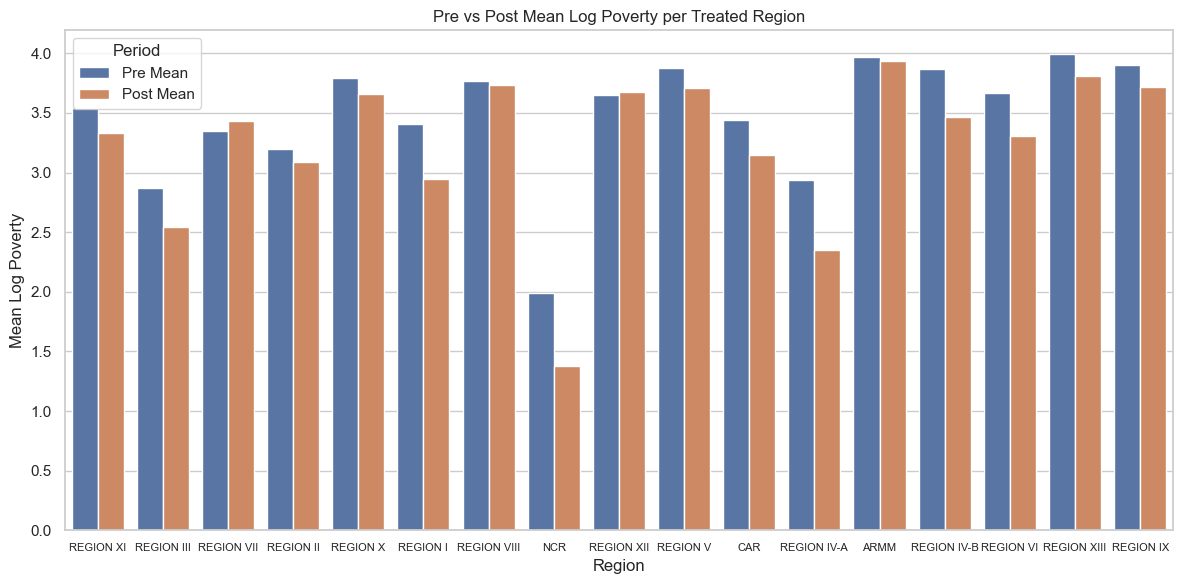

In [66]:
sns.set(style="whitegrid")
# Melt the ttest_results DataFrame for easier plotting
melted = ttest_results.melt(id_vars='Region', 
                            value_vars=['Pre Mean', 'Post Mean'], 
                            var_name='Period', 
                            value_name='Mean Log Poverty')

# Create barplot
plt.figure(figsize=(12, 6))
sns.barplot(data=melted, x='Region', y='Mean Log Poverty', hue='Period')

# Customize
plt.title('Pre vs Post Mean Log Poverty per Treated Region')
plt.xticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.legend(title='Period')
plt.grid(True, axis='y')

plt.show()

## Network Analysis

In [2]:
# Load the data
df = pd.read_excel("ASOG.xlsx")

# Filter for 2016 only
df_2016 = df[df["Year"] == 2016].copy()

# Create a Full Name column
df_2016["Full Name"] = df_2016["First Name"] + " " + df_2016["Last Name"]

# Select necessary columns
df_selected = df_2016[['Full Name', 'Party', 'Region', 'Year', 'fat']]

print(df_selected.head())

             Full Name Party                                Region  Year  fat
10  SHIRLEY BELEN AALA    LP                             REGION XI  2016    1
11  TRISTAN ROYCE AALA    LP                             REGION XI  2016    1
14      JOSE JOEL AALA    LP                           REGION IV-A  2016    0
15      MANGIGIN AARON   IND  Autonomous Region in Muslim Mindanao  2016    0
18          DARYLL ABA   NPC                            REGION VII  2016    0


### Person vs Region

In [15]:
# Build Bipartite Graph
B = nx.Graph()
people = df_selected["Full Name"].unique()

# Add nodes
B.add_nodes_from(people, bipartite='people')

# Create tags for relationship criteria
for _, row in df_selected.iterrows():
    tags = [
        f"region_{row['Region']}",
        f"party_{row['Party']}",
        f"fat_{row['fat']}"
    ]
    for tag in tags:
        B.add_node(tag, bipartite='tag')
        B.add_edge(row["Full Name"], tag)

In [17]:
# Build biadjacency matrix
people_nodes = list(n for n, d in B.nodes(data=True) if d["bipartite"] == "people")
tag_nodes = list(n for n in B if n not in people_nodes)
M = biadjacency_matrix(B, row_order=people_nodes, column_order=tag_nodes)

In [19]:
# Compute projection
P = M @ M.T

# Remove diagonal elements (self-loops)
P.setdiag(0)
P.eliminate_zeros()

# Keep only upper triangle (to avoid duplicate edges)
P_upper = triu(P, k=1)

# Filter edges by weight threshold (e.g., > 1 to keep meaningful connections)
threshold = 1

# Convert to COO format for filtering
coo = P_upper.tocoo()

# Filter edges
mask = coo.data > threshold
rows = coo.row[mask]
cols = coo.col[mask]
data = coo.data[mask]

In [21]:
# Projected Graph (Person to Person)
projected = nx.Graph()
for i, j, w in zip(coo.row, coo.col, coo.data):
    if w >= 2:  # threshold to filter weak ties (can adjust to 1)
        projected.add_edge(people_nodes[i], people_nodes[j], weight=int(w))

In [23]:
# top 100 nodes
top_nodes = sorted(projected.degree, key=lambda x: x[1], reverse=True)[:100]
top_names = [n for n, _ in top_nodes]
subG = projected.subgraph(top_names)

In [25]:
# Centrality Table
deg = nx.degree_centrality(subG)
close = nx.closeness_centrality(subG)
eig = nx.eigenvector_centrality(subG, max_iter=200)

centrality_data = []
for node in subG.nodes():
    row = df_selected[df_selected["Full Name"] == node].iloc[0]
    centrality_data.append({
        "Name": node,
        "Region": row["Region"],
        "Degree Centrality": deg[node],
        "Closeness Centrality": close[node],
        "Eigenvector Centrality": eig[node]
    })
# Convert to DataFrame
centrality_df = pd.DataFrame(centrality_data)

# Display top 10
print(centrality_df.head(10).to_string(index=False))

                   Name      Region  Degree Centrality  Closeness Centrality  Eigenvector Centrality
    ANTONIO TATLONGHARI REGION IV-A                1.0                   1.0                     0.1
           MARIETTE ROM REGION IV-A                1.0                   1.0                     0.1
       JAIME SALANDANAN REGION IV-A                1.0                   1.0                     0.1
         BENJAMIN TUALA REGION IV-A                1.0                   1.0                     0.1
ALEXANDER SR. TOLENTINO REGION IV-A                1.0                   1.0                     0.1
   JOSE JERIEL VILLEGAS REGION IV-A                1.0                   1.0                     0.1
            JAIME VISTA REGION IV-A                1.0                   1.0                     0.1
         ARTURO TIONGCO REGION IV-A                1.0                   1.0                     0.1
          AILEEN SALUDO REGION IV-A                1.0                   1.0               

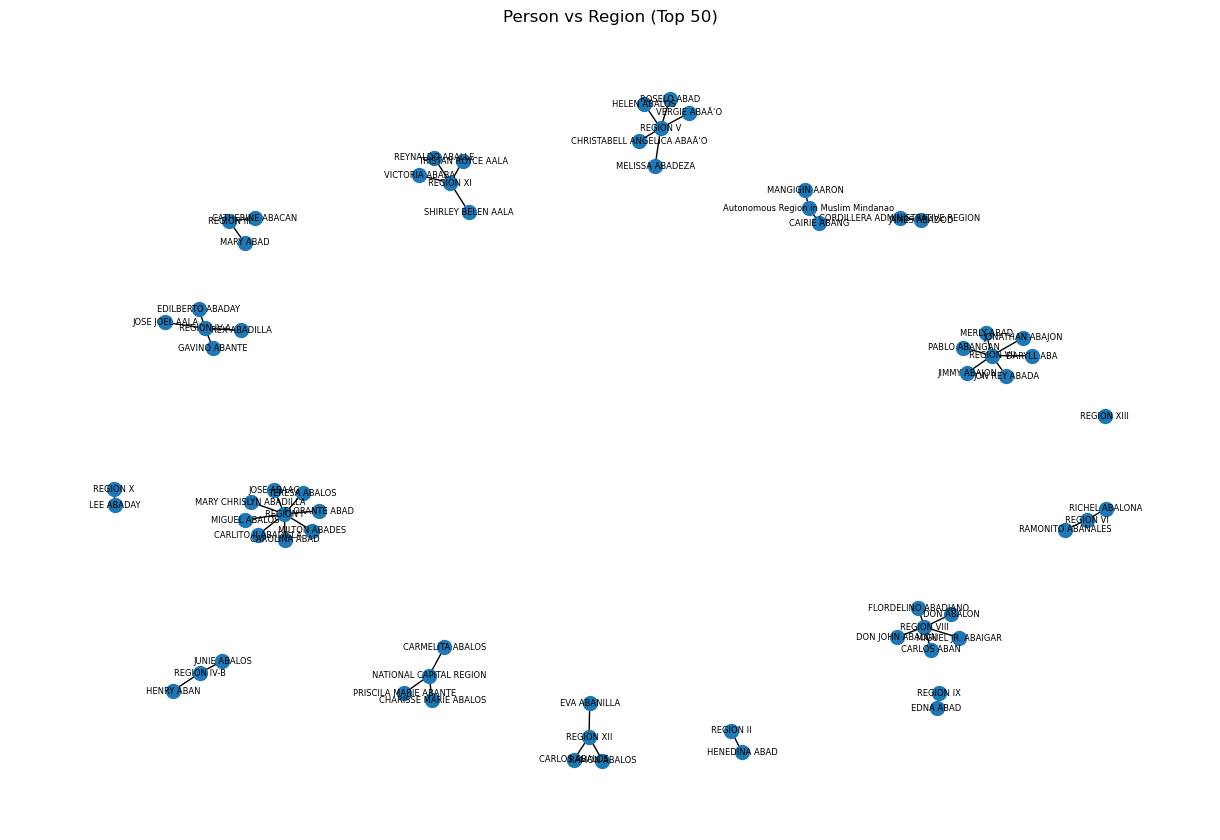

In [27]:
# Bipartite Projection (Person vs Region)
person_region = nx.Graph()
regions = df_selected["Region"].unique()

# Add nodes and edges
for _, row in df_selected.iterrows():
    person = row["Full Name"]
    region = row["Region"]
    person_region.add_node(person, bipartite='person')
    person_region.add_node(region, bipartite='region')
    person_region.add_edge(person, region)

# Plot Person vs Region (simplified to top 50 people for clarity)
plt.figure(figsize=(12, 8))
sub = person_region.subgraph(list(df_selected["Full Name"].unique())[:50] + list(regions))
pos = nx.spring_layout(sub, seed=42)
nx.draw(sub, pos, with_labels=True, node_size=100, font_size=6)
plt.title("Person vs Region (Top 50)")
plt.show()

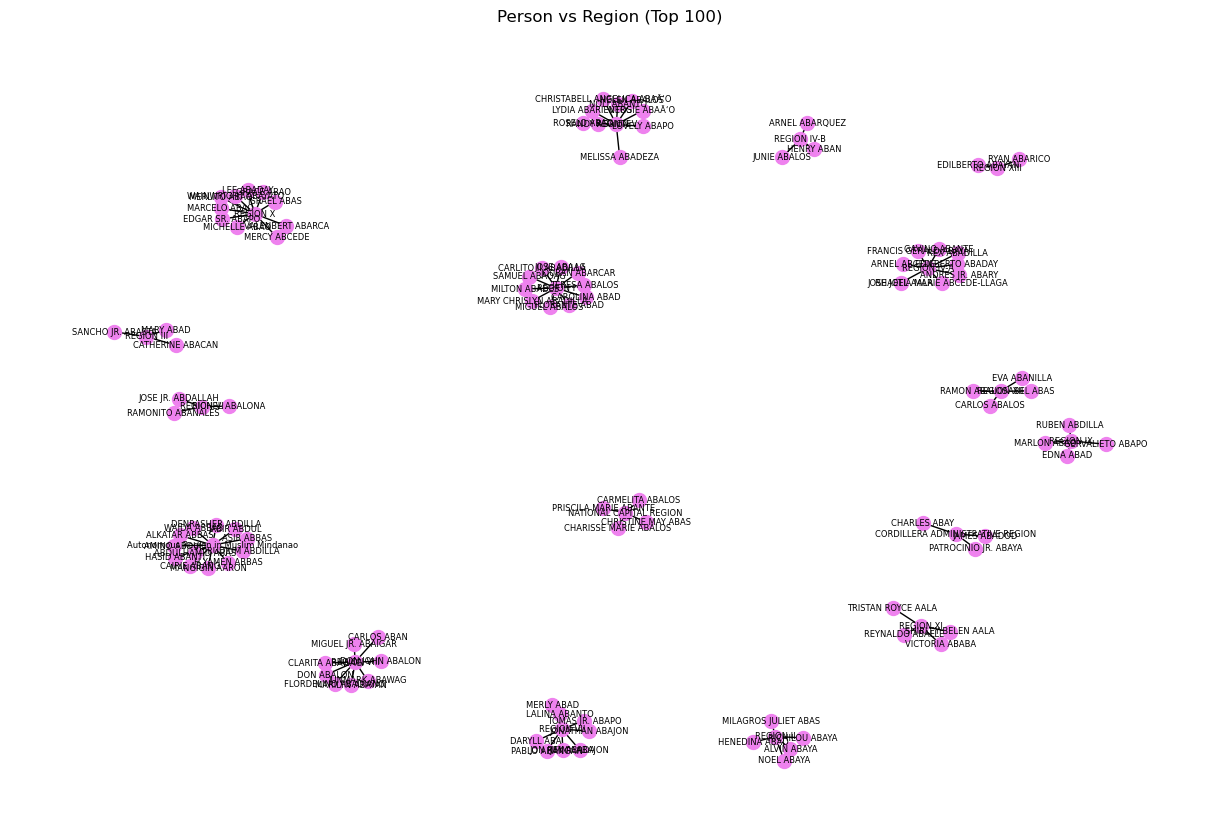

In [29]:
# Bipartite Projection (Person vs Region)
person_region = nx.Graph()
regions = df_selected["Region"].unique()

# Add nodes and edges
for _, row in df_selected.iterrows():
    person = row["Full Name"]
    region = row["Region"]
    person_region.add_node(person, bipartite='person')
    person_region.add_node(region, bipartite='region')
    person_region.add_edge(person, region)

# Plot Person vs Region (simplified to top 50 people for clarity)
plt.figure(figsize=(12, 8))
sub = person_region.subgraph(list(df_selected["Full Name"].unique())[:100] + list(regions))
pos = nx.spring_layout(sub, seed=42)
nx.draw(sub, pos, with_labels=True, node_size=100, node_color='violet', font_size=6)
plt.title("Person vs Region (Top 100)")
plt.show()

### Person to Person

In [3]:
# Filter to dynastic cases
df_dynastic = df_2016[df_2016["fat"] == 1][['Full Name', 'Last Name', 'Party', 'Region']].copy()
people = df_dynastic.to_dict("records")

# Create Graph: Only Full Names as nodes
B = nx.Graph()
for person in df_dynastic["Full Name"].unique():
    B.add_node(person, bipartite='person')

# Add edges only when family relationship is strongly inferred
for p1, p2 in combinations(people, 2):
    if p1["Last Name"] == p2["Last Name"]:
        if (p1["Region"] == p2["Region"]) or (p1["Party"] == p2["Party"]):
            B.add_edge(p1["Full Name"], p2["Full Name"])

print("🧠 Filtered Dynastic Graph")
print("Nodes:", B.number_of_nodes())
print("Edges:", B.number_of_edges())

🧠 Filtered Dynastic Graph
Nodes: 5004
Edges: 9434


In [4]:
# Extract Top 100 by Degree
top100 = sorted(B.degree, key=lambda x: x[1], reverse=True)[:100]
top_names = [n for n, _ in top100]
subG = B.subgraph(top_names).copy()

In [5]:
# Centralities
deg_cent = nx.degree_centrality(subG)
close_cent = nx.closeness_centrality(subG)
eig_cent = nx.eigenvector_centrality(subG, max_iter=500)

In [6]:
# Build a dictionary to map Full Name → Region directly from df_dynastic
region_map = df_dynastic.set_index("Full Name")["Region"].to_dict()

In [7]:
# centrality table 
data = []
for node in subG.nodes():
    data.append({
        "Full Name": node,
        "Region": region_map.get(node),
        "Degree Centrality": deg_cent.get(node),
        "Closeness Centrality": close_cent.get(node),
        "Eigenvector Centrality": eig_cent.get(node)
    })

centrality_df = pd.DataFrame(data)
centrality_df = centrality_df.sort_values(by="Degree Centrality", ascending=False).reset_index(drop=True)

print(centrality_df.head(10))

            Full Name       Region  Degree Centrality  Closeness Centrality  \
0         ORLANDO TAN  REGION VIII           0.343434              0.343434   
1      LEONARD II TAN  REGION VIII           0.343434              0.343434   
2         ALFONSO TAN  REGION VIII           0.343434              0.343434   
3       ALBERTO REYES  REGION IV-A           0.272727              0.252525   
4        KARINA REYES  REGION IV-A           0.252525              0.252525   
5      JONALINA REYES  REGION IV-A           0.252525              0.252525   
6      CRISTETA REYES  REGION IV-A           0.252525              0.252525   
7        DANIEL REYES  REGION IV-A           0.252525              0.252525   
8  ARGEL JOSEPH REYES  REGION IV-A           0.252525              0.252525   
9        PEPITO REYES  REGION IV-A           0.252525              0.252525   

   Eigenvector Centrality  
0                0.000110  
1                0.000110  
2                0.000110  
3                0

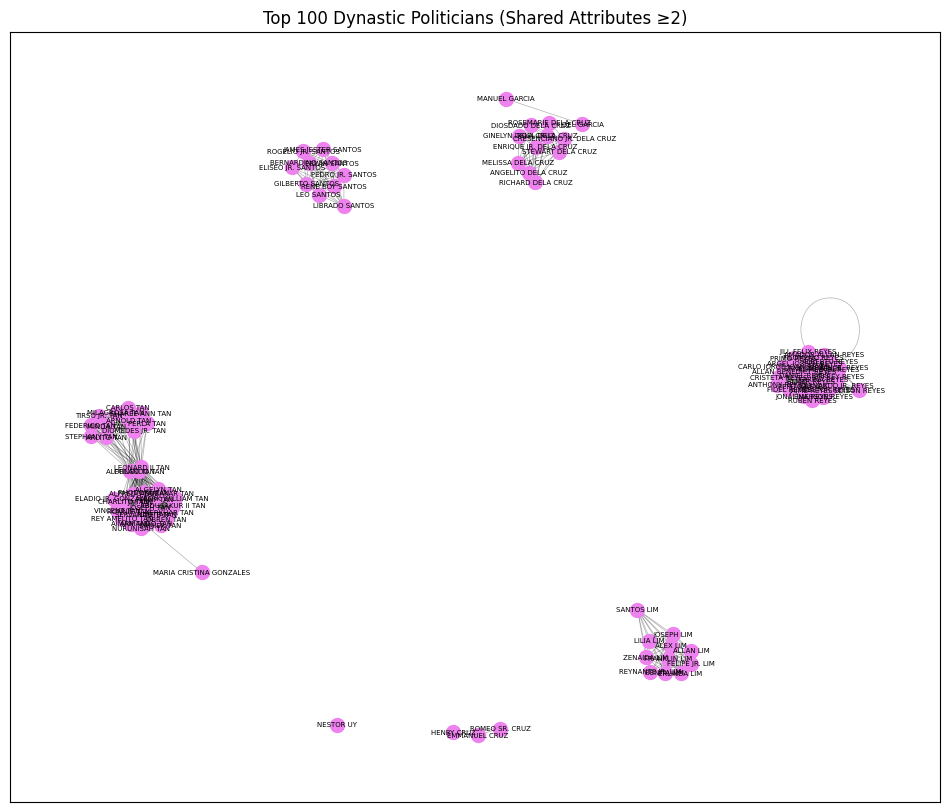

In [8]:
# Visualization: Top 100
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(subG, seed=36, k=0.5, iterations=100)
nx.draw_networkx_edges(subG, pos, alpha=0.3, width=0.5, edge_color='black')
nx.draw_networkx_nodes(subG, pos, node_size=100, node_color='violet')
nx.draw_networkx_labels(subG, pos, font_size=5)
plt.title("Top 100 Dynastic Politicians (Shared Attributes ≥2)")
plt.show()

##### Girvan-Newman Community Detection

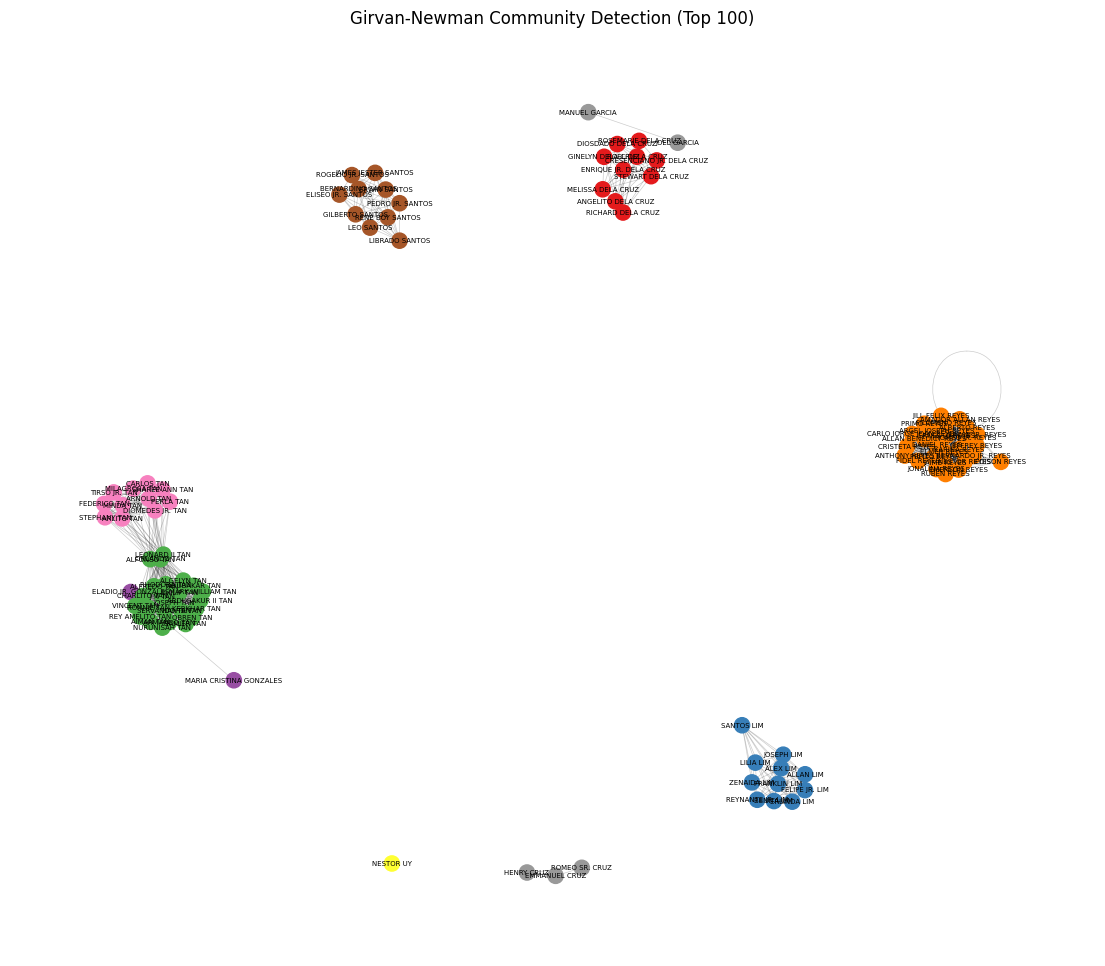

In [9]:
# Girvan-Newman
comp = girvan_newman(subG)
communities = tuple(sorted(c) for c in next(comp))
comm_map = {}
for i, community in enumerate(communities):
    for node in community:
        comm_map[node] = i

colors = [comm_map.get(node, 0) for node in subG.nodes()]
plt.figure(figsize=(14, 12))
nx.draw_networkx_nodes(subG, pos, node_size=120, cmap=plt.cm.Set1, 
                       node_color=colors)
nx.draw_networkx_edges(subG, pos, alpha=0.2, width=0.5)
nx.draw_networkx_labels(subG, pos, font_size=5)
plt.title("Girvan-Newman Community Detection (Top 100)")
plt.axis('off')
plt.show()

##### Louvain Partition Community Detection

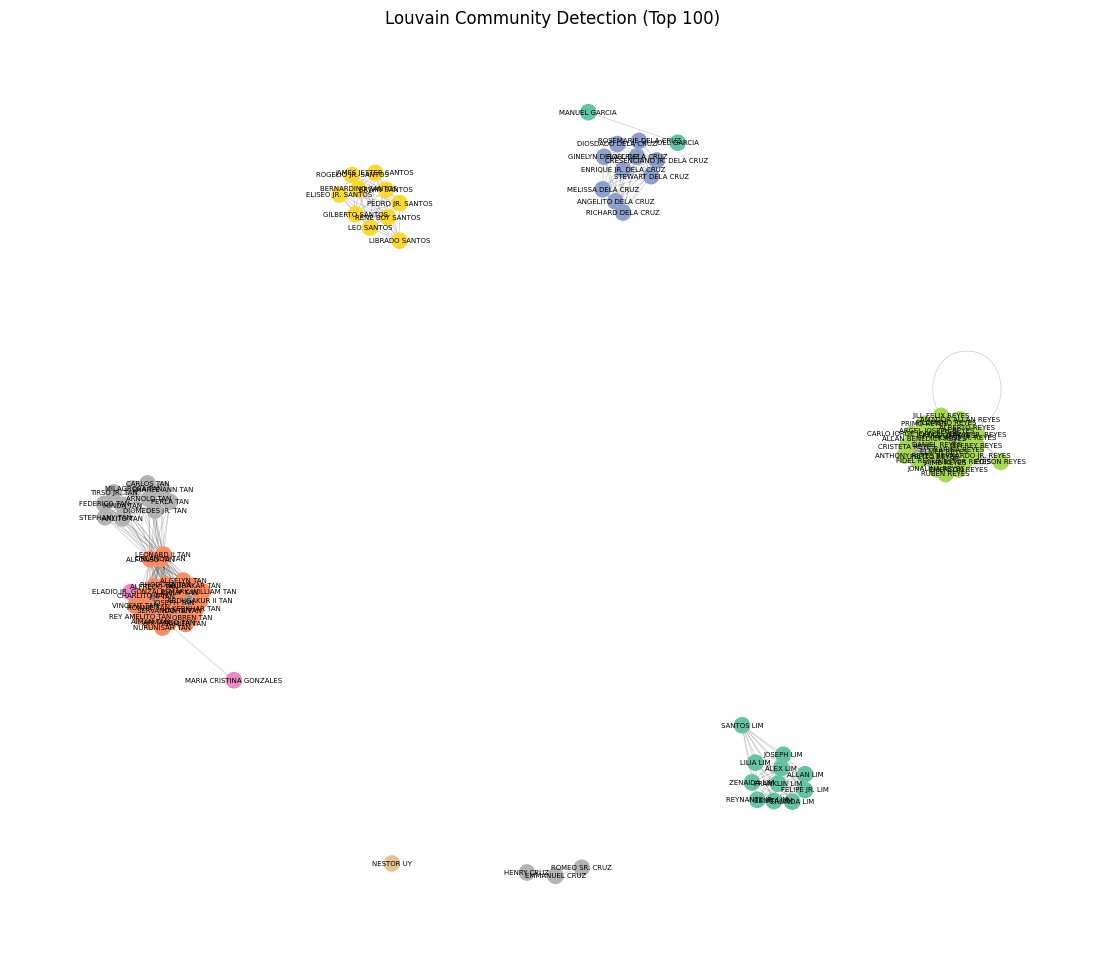

In [12]:
# Louvain partition
partition = community_louvain.best_partition(subG)
colors = [partition.get(node, 0) for node in subG.nodes()]

plt.figure(figsize=(14, 12))
nx.draw_networkx_nodes(subG, pos, node_size=120, cmap=plt.cm.Set2,
                       node_color=colors)
nx.draw_networkx_edges(subG, pos, alpha=0.2, width=0.5)
nx.draw_networkx_labels(subG, pos, font_size=5)
plt.title("Louvain Community Detection (Top 100)")
plt.axis('off')
plt.show()

In [11]:
# centrality and community table 
data = []
for node in subG.nodes():
    data.append({
        "Full Name": node,
        "Region": region_map.get(node),
        "Degree Centrality": deg_cent.get(node),
        "Closeness Centrality": close_cent.get(node),
        "Eigenvector Centrality": eig_cent.get(node),
        "Girvan-Newman Cluster": comm_map.get(node),
        "Louvain Cluster": partition.get(node)
    })

centrality_df = pd.DataFrame(data)
centrality_df = centrality_df.sort_values(by="Degree Centrality", ascending=False).reset_index(drop=True)

print(centrality_df.head(10))

centrality_df.to_excel("centrality_top100.xlsx", index=False)

            Full Name       Region  Degree Centrality  Closeness Centrality  \
0         ORLANDO TAN  REGION VIII           0.343434              0.343434   
1      LEONARD II TAN  REGION VIII           0.343434              0.343434   
2         ALFONSO TAN  REGION VIII           0.343434              0.343434   
3       ALBERTO REYES  REGION IV-A           0.272727              0.252525   
4        KARINA REYES  REGION IV-A           0.252525              0.252525   
5      JONALINA REYES  REGION IV-A           0.252525              0.252525   
6      CRISTETA REYES  REGION IV-A           0.252525              0.252525   
7        DANIEL REYES  REGION IV-A           0.252525              0.252525   
8  ARGEL JOSEPH REYES  REGION IV-A           0.252525              0.252525   
9        PEPITO REYES  REGION IV-A           0.252525              0.252525   

   Eigenvector Centrality  Girvan-Newman Cluster  Louvain Cluster  
0                0.000110                      2              

### Fat Dynasties by Region and Year

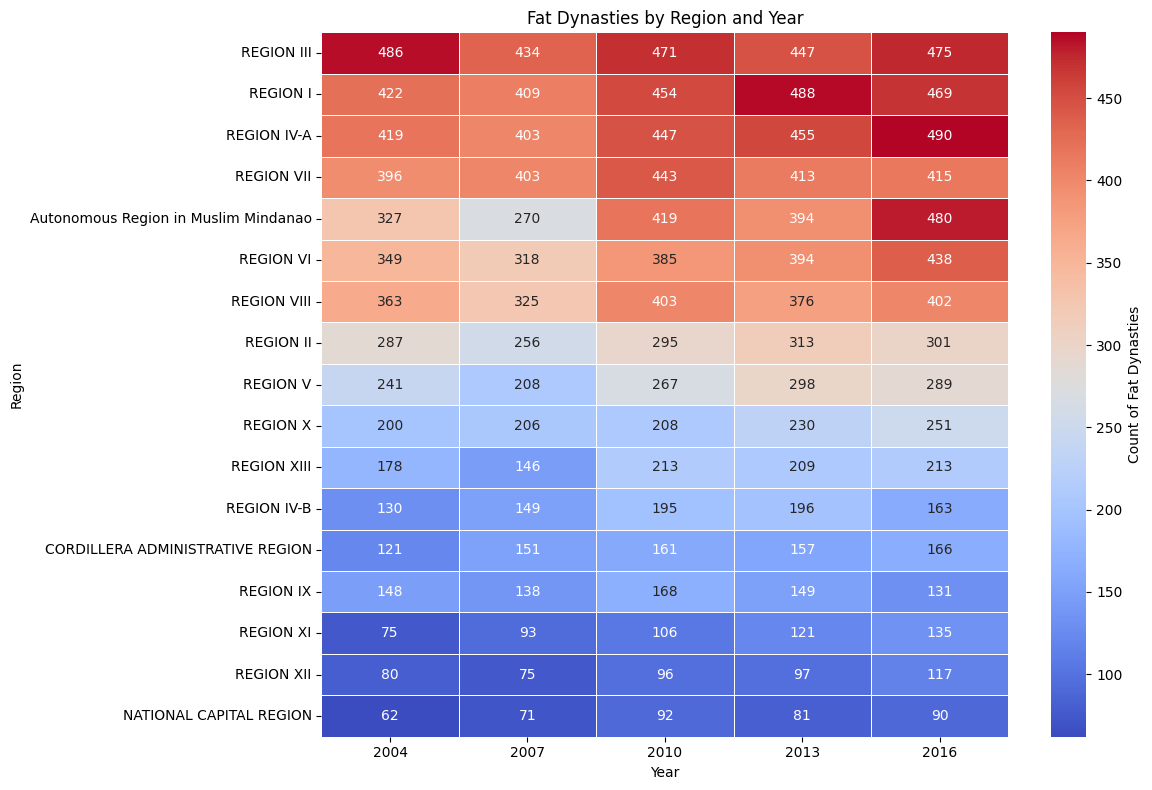

In [13]:
# Filter for fat dynasties only (fat == 1)
df_fat = df[df["fat"] == 1].copy()

# Group by Region and Year, and count fat dynasties
heatmap_data = df_fat.groupby(["Region", "Year"]).size().unstack(fill_value=0)

# Sort rows by total fat dynasties over the years (optional, for readability)
heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1).sort_values(ascending=False).index]

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt="d", linewidths=0.5, cbar_kws={'label': 'Count of Fat Dynasties'})
plt.title("Fat Dynasties by Region and Year")
plt.ylabel("Region")
plt.xlabel("Year")
plt.tight_layout()
plt.show()